In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad
import multiprocessing as mp
import gc
import matplotlib.colors as colors
from matplotlib import rcParams 
from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic_2d
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

In [2]:
plt.rc('font',size=25)
pd.set_option('max_column',200)

In [3]:
plt.rcParams.update({'figure.figsize': (6, 6),
                   'font.size':25,
                   'text.usetex':True,
                   'mathtext.default' : 'it',
                   'axes.labelsize': 32,
                   'legend.fontsize': 25,
                   'legend.fancybox': False,
                   'legend.numpoints': 1,
                   'xtick.labelsize': 32,
                   'ytick.labelsize': 32,
                   'ytick.major.width':0.8,
                   'ytick.major.size':8,
                   'ytick.minor.size':4,
                   'xtick.major.width': 0.8,
                   'xtick.major.size':8,
                   'xtick.minor.size':4,
                   'axes.linewidth':2,
                   'lines.linewidth':2,
                   'xtick.direction':'in',
                   'ytick.direction':'in',
                   'savefig.bbox': 'tight', # 'tight' or 'standard'.
                   'savefig.pad_inches' : 0.1})
plt.rc('font',**{'family':'serif','serif':['Computer Modern'],'sans-serif':['Computer Modern']})

from matplotlib.ticker import FuncFormatter
#%matplotlib inline

import glob

In [4]:
# given vectors x and y, fit medians in bins from xMin to xMax, with Nbin steps,
# and return xBin, medianBin, medianErrBin 
def fitMedians(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    medianBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = [-1+0*np.linspace(0, 1, Nbin),-1+0*np.linspace(0, 1, Nbin)] #lower and upper
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux1 = y[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = ye[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = yErr[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
        if (yAux1.size > 0):
            yAux = yAux1#[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
            nPts[i] = yAux.size
            medianBin[i] = np.median(yAux) #mean
            # robust estimate of standard deviation: 0.741*(q75-q50),0.741*(q50-q25)
            sigmaG1 = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,50))*2
            sigmaG2 = 0.741*(np.percentile(yAux,50)-np.percentile(yAux,25))*2
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            sigGbin[0][i] = np.sqrt(np.pi/2)*sigmaG2/np.sqrt(nPts[i])
            sigGbin[1][i] = np.sqrt(np.pi/2)*sigmaG1/np.sqrt(nPts[i])
        else:
            nPts[i] = 0 
            medianBin[i] = np.nan
            sigGbin[0][i] = np.nan
            sigGbin[1][i] = np.nan 
            # nPts[i], medianBin[i], sigGBin[i] = 0 
        
    if (verbose):
        print('median:', np.median(medianBin[nPts>0]))

    return xBin, nPts, medianBin, sigGbin

# gaia results including recalibration of DCR

In [6]:
g=pd.read_csv('../Downloads/catalog/final/matchedgaia3.csv')

In [7]:
g=g[g.gi<4]

In [8]:
len(g)

117703

In [9]:
g=g[(g.i_sdsscentroid_ra<4)|(g.i_sdsscentroid_ra>5)]

In [205]:
g1=pd.read_csv('../Downloads/1581343635132O-result.csv')

In [206]:
g=pd.merge(g,g1,on='source_id')

In [10]:
len(g)

117703

In [305]:
g.to_csv('../Downloads/catalog/final/matchedgaia3.csv',index=False)

In [11]:
def sig1(a):
    s=(0.741*(np.percentile(a,75)-np.percentile(a,50)))*2
    e=np.sqrt(np.pi/2)*s/np.sqrt(len(a))
    return e
def sig2(a):
    s=(0.741*(np.percentile(a,50)-np.percentile(a,25)))*2
    e=np.sqrt(np.pi/2)*s/np.sqrt(len(a))
    return e

In [254]:
ra=g.i_sdsscentroid_ra
pmra1=g.pmra_2
pmra2=g.pmra_cl
pmra3=g.pmra_cl-g.pmra_2
#pmra3=pmra3[pd.notna(pmra3)]
pmdec1=g.pmdec_2
pmdec2=g.pmdec_cl
pmdec3=g.pmdec_cl-g.pmdec_2
#pmdec3=pmdec3[pd.notna(pmdec3)]
x1Bin1, n1Pts1, m1edianBin1, s1igGbin1 = fitMedians(ra, pmra1, -30, 36, 66, 0)#gaia
x1Bin2, n1Pts2, m1edianBin2, s1igGbin2 = fitMedians(ra, pmra2, -30, 36, 66, 0)#HSC-S82
#difference
s1igGbin3=s1igGbin1
x1Bin3 = x1Bin1
m1edianBin3=m1edianBin2-m1edianBin1
s1igGbin3[0]=np.sqrt(s1igGbin2[0]**2+s1igGbin1[1]**2)
s1igGbin3[1]=np.sqrt(s1igGbin2[1]**2+s1igGbin1[0]**2)

x1Bin11, n1Pts11, m1edianBin11, s1igGbin11 = fitMedians(ra, pmdec1, -30, 36, 66, 0)
x1Bin21, n1Pts21, m1edianBin21, s1igGbin21 = fitMedians(ra, pmdec2, -30, 36, 66, 0)
#difference
x1Bin31 = x1Bin11
s1igGbin31=s1igGbin11
m1edianBin31=m1edianBin21-m1edianBin11
s1igGbin31[0]=np.sqrt(s1igGbin21[0]**2+s1igGbin11[1]**2)
s1igGbin31[1]=np.sqrt(s1igGbin21[1]**2+s1igGbin11[0]**2)
    

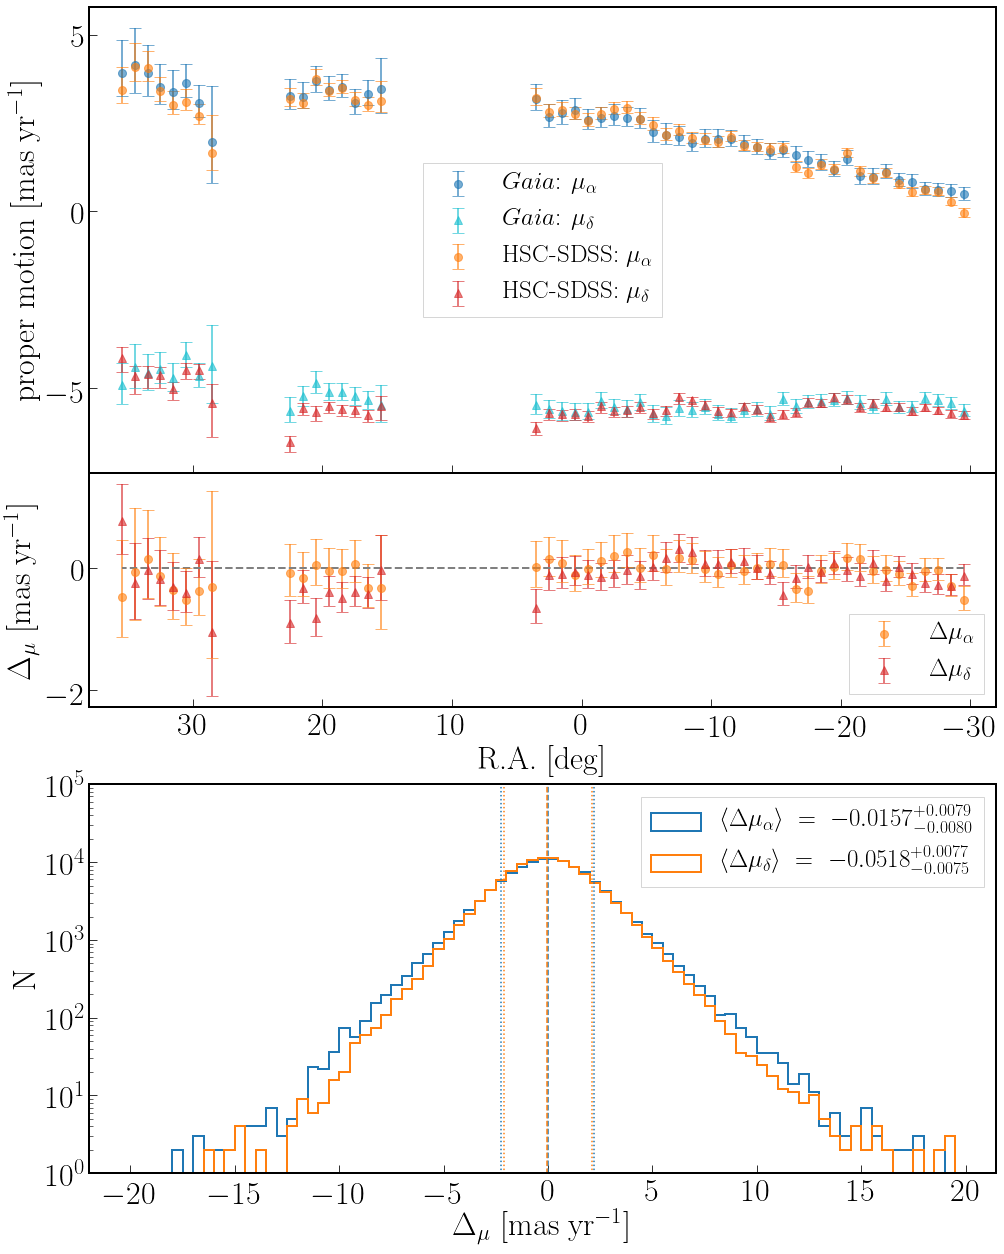

In [256]:
plt.figure(figsize=(14,18))
ax=plt.axes([0.05,0.59,0.9,0.36])
#plt.title(r'$\mu_\alpha$ and $\mu_\delta$ versus R.A. by stars matched with Gaia')
#plt.hlines(np.mean(mss.dra_cl),np.min(xm),np.max(xm),color='darkblue')
#plt.hlines(np.mean(mss.ddec_cl),np.min(xm),np.max(xm),color='darkred')
#plt.plot(xm,np.array(ram),color='darkblue')
#plt.plot(xm,np.array(decm),color='darkred')
plt.errorbar(x1Bin1,m1edianBin1,s1igGbin1,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:blue',label=r'$Gaia$: $\mu_\alpha$')
plt.errorbar(x1Bin11,m1edianBin11,s1igGbin11,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:cyan',label=r'$Gaia$: $\mu_\delta$')
#plt.plot(xm,ram3,color='cyan')
#plt.plot(xm,decm3,color='pink')
plt.errorbar(x1Bin2,m1edianBin2,s1igGbin2,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:orange',label=r'HSC-SDSS: $\mu_\alpha$')
plt.errorbar(x1Bin21,m1edianBin21,s1igGbin21,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:red',label=r'HSC-SDSS: $\mu_\delta$')
plt.legend(loc=10)
plt.xlim(38,-32)
ax.yaxis.set_major_locator(MultipleLocator(5))
plt.ylabel('proper motion [$\mathrm{mas\ yr^{-1}}$]',fontsize=32)
ax=plt.axes([0.05,0.41,0.9,0.18])
plt.errorbar(x1Bin3,m1edianBin3,s1igGbin3,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:orange',label=r'$\Delta\mu_\alpha$')
plt.errorbar(x1Bin31,m1edianBin31,s1igGbin31,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:red',label=r'$\Delta\mu_\delta$')
plt.hlines(0,min(x1Bin1),max(x1Bin1),color='grey',linestyle='dashed')
plt.legend()
plt.xlim(38,-32)
plt.xlabel('R.A. [deg]')
plt.ylabel('$\Delta_\mu$ [$\mathrm{mas\ yr^{-1}}$]',fontsize=32)


ax=plt.axes([0.05,0.05,0.9,0.3])
plt.hist(pmra3,bins=np.arange(-20,20,0.5),linewidth=2,histtype='step',color='tab:blue',label=r'$\langle \Delta\mu_{\alpha}\rangle \ = \ %0.4f^{+%0.4f}_{-%0.4f}$'\
         %(np.median(pmra3),sig1(pmra3.values),sig2(pmra3.values)))#,np.std(g.pmra_2-g.pmra_cl)))
plt.vlines(np.median(pmra3),0,1e5,linewidth=1.5,linestyles='dashed',color='tab:blue')
plt.hist(pmdec3,bins=np.arange(-20,20,0.5),linewidth=2,histtype='step',color='tab:orange',label=r'$\langle \Delta\mu_{\delta}\rangle\ =\ %0.4f^{+%0.4f}_{-%0.4f}$'\
         %(np.median(pmdec3),sig1(pmdec3.values),sig2(pmdec3.values)))#,np.std(g.pmdec_2-g.pmdec_cl)))
plt.vlines(np.median(pmdec3),0,1e5,linewidth=1.5,linestyles='dashed',color='tab:orange')
plt.vlines(np.percentile(pmra3,16),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:blue')
plt.vlines(np.percentile(pmra3,84),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:blue')
plt.vlines(np.percentile(pmdec3,16),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:orange')
plt.vlines(np.percentile(pmdec3,84),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:orange')
plt.yscale('log')
plt.ylim([1,1e5])
plt.ylabel('N',fontsize=32)
plt.xlabel(r'$\Delta_\mu\ [\mathrm{mas\ yr^{-1}}]$',fontsize=32)
plt.legend()
plt.savefig('/Users/tianqiu/Documents/final/newgaia/gaia.pdf')

In [257]:
np.percentile(pmra3,84),np.percentile(pmra3,16)

(2.2060801822296083, -2.2695708863662163)

In [259]:
ra=g.i_sdsscentroid_ra
pmra1=g.pmra_2
pmra2=g.pmra_1
pmra3=g.pmra_1-g.pmra_2
pmdec1=g.pmdec_2
pmdec2=g.pmdec_1
pmdec3=g.pmdec_1-g.pmdec_2

x1Bin1, n1Pts1, m1edianBin1, s1igGbin1 = fitMedians(ra, pmra1, -30, 36, 66, 0)#gaia
x1Bin2, n1Pts2, m1edianBin2, s1igGbin2 = fitMedians(ra, pmra2, -30, 36, 66, 0)#HSC-S82
#difference
s1igGbin3=s1igGbin1
x1Bin3 = x1Bin1
m1edianBin3=m1edianBin2-m1edianBin1
s1igGbin3[0]=np.sqrt(s1igGbin2[0]**2+s1igGbin1[1]**2)
s1igGbin3[1]=np.sqrt(s1igGbin2[1]**2+s1igGbin1[0]**2)

x1Bin11, n1Pts11, m1edianBin11, s1igGbin11 = fitMedians(ra, pmdec1, -30, 36, 66, 0)
x1Bin21, n1Pts21, m1edianBin21, s1igGbin21 = fitMedians(ra, pmdec2, -30, 36, 66, 0)
#difference
x1Bin31 = x1Bin11
s1igGbin31=s1igGbin11
m1edianBin31=m1edianBin21-m1edianBin11
s1igGbin31[0]=np.sqrt(s1igGbin21[0]**2+s1igGbin11[1]**2)
s1igGbin31[1]=np.sqrt(s1igGbin21[1]**2+s1igGbin11[0]**2)
    

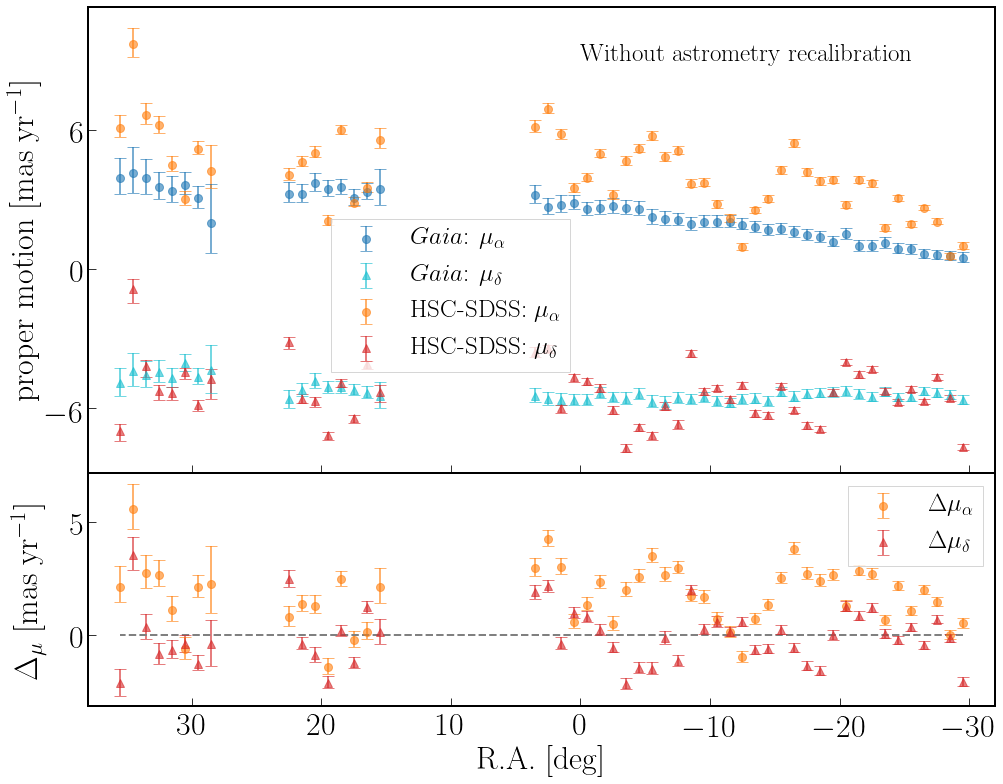

In [260]:
plt.figure(figsize=(14,18))
ax=plt.axes([0.05,0.59,0.9,0.36])
#plt.title(r'$\mu_\alpha$ and $\mu_\delta$ versus R.A. by stars matched with Gaia')
#plt.hlines(np.mean(mss.dra_cl),np.min(xm),np.max(xm),color='darkblue')
#plt.hlines(np.mean(mss.ddec_cl),np.min(xm),np.max(xm),color='darkred')
#plt.plot(xm,np.array(ram),color='darkblue')
#plt.plot(xm,np.array(decm),color='darkred')
plt.errorbar(x1Bin1,m1edianBin1,s1igGbin1,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:blue',label=r'$Gaia$: $\mu_\alpha$')
plt.errorbar(x1Bin11,m1edianBin11,s1igGbin11,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:cyan',label=r'$Gaia$: $\mu_\delta$')
#plt.plot(xm,ram3,color='cyan')
#plt.plot(xm,decm3,color='pink')
plt.errorbar(x1Bin2,m1edianBin2,s1igGbin2,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:orange',label=r'HSC-SDSS: $\mu_\alpha$')
plt.errorbar(x1Bin21,m1edianBin21,s1igGbin21,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:red',label=r'HSC-SDSS: $\mu_\delta$')
plt.legend(bbox_to_anchor=(0.4,0.19))
plt.text(0,9,'Without astrometry recalibration')
plt.xlim(38,-32)
ax.yaxis.set_major_locator(MultipleLocator(6))
plt.ylabel('proper motion [$\mathrm{mas\ yr^{-1}}$]',fontsize=32)
ax=plt.axes([0.05,0.41,0.9,0.18])
plt.errorbar(x1Bin3,m1edianBin3,s1igGbin3,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:orange',label=r'$\Delta\mu_\alpha$')
plt.errorbar(x1Bin31,m1edianBin31,s1igGbin31,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:red',label=r'$\Delta\mu_\delta$')
plt.hlines(0,min(x1Bin1),max(x1Bin1),color='grey',linestyle='dashed')
plt.legend()
plt.xlim(38,-32)
plt.xlabel('R.A. [deg]')
plt.ylabel('$\Delta_\mu$ [$\mathrm{mas\ yr^{-1}}$]',fontsize=32,labelpad=20)
plt.savefig('/Users/tianqiu/Documents/final/newgaia/gaia_wo_astrometry_calibration.pdf')

In [261]:
g['pmra_12']=g.pmra_cl*g.delta_yr/12
g['pmdec_12']=g.pmdec_cl*g.delta_yr/12

In [262]:
ra=g.i_sdsscentroid_ra
pmra1=g.pmra_2
pmra2=g.pmra_12
pmra3=g.pmra_12-g.pmra_2
pmdec1=g.pmdec_2
pmdec2=g.pmdec_12
pmdec3=g.pmdec_12-g.pmdec_2

x1Bin1, n1Pts1, m1edianBin1, s1igGbin1 = fitMedians(ra, pmra1, -30, 36, 66, 0)#gaia
x1Bin2, n1Pts2, m1edianBin2, s1igGbin2 = fitMedians(ra, pmra2, -30, 36, 66, 0)#HSC-S82
#difference
s1igGbin3=s1igGbin1
x1Bin3 = x1Bin1
m1edianBin3=m1edianBin2-m1edianBin1
s1igGbin3[0]=np.sqrt(s1igGbin2[0]**2+s1igGbin1[1]**2)
s1igGbin3[1]=np.sqrt(s1igGbin2[1]**2+s1igGbin1[0]**2)

x1Bin11, n1Pts11, m1edianBin11, s1igGbin11 = fitMedians(ra, pmdec1, -30, 36, 66, 0)
x1Bin21, n1Pts21, m1edianBin21, s1igGbin21 = fitMedians(ra, pmdec2, -30, 36, 66, 0)
#difference
x1Bin31 = x1Bin11
s1igGbin31=s1igGbin11
m1edianBin31=m1edianBin21-m1edianBin11
s1igGbin31[0]=np.sqrt(s1igGbin21[0]**2+s1igGbin11[1]**2)
s1igGbin31[1]=np.sqrt(s1igGbin21[1]**2+s1igGbin11[0]**2)
    

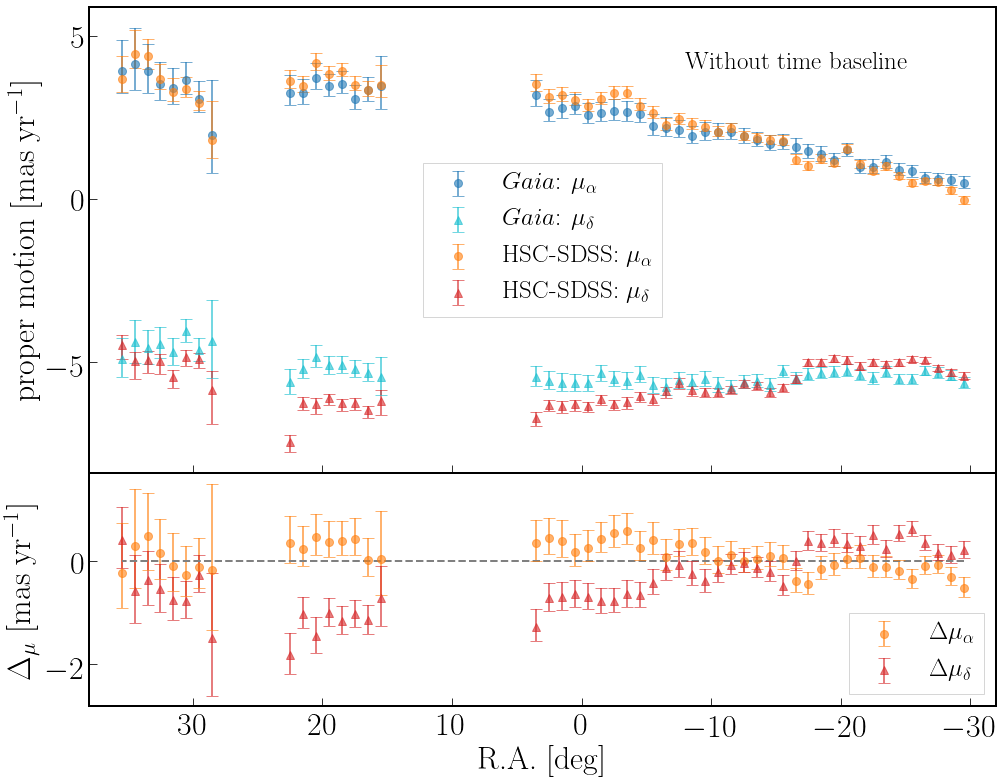

In [264]:
plt.figure(figsize=(14,18))
ax=plt.axes([0.05,0.59,0.9,0.36])
#plt.title(r'$\mu_\alpha$ and $\mu_\delta$ versus R.A. by stars matched with Gaia')
#plt.hlines(np.mean(mss.dra_cl),np.min(xm),np.max(xm),color='darkblue')
#plt.hlines(np.mean(mss.ddec_cl),np.min(xm),np.max(xm),color='darkred')
#plt.plot(xm,np.array(ram),color='darkblue')
#plt.plot(xm,np.array(decm),color='darkred')
plt.errorbar(x1Bin1,m1edianBin1,s1igGbin1,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:blue',label=r'$Gaia$: $\mu_\alpha$')
plt.errorbar(x1Bin11,m1edianBin11,s1igGbin11,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:cyan',label=r'$Gaia$: $\mu_\delta$')
#plt.plot(xm,ram3,color='cyan')
#plt.plot(xm,decm3,color='pink')
plt.errorbar(x1Bin2,m1edianBin2,s1igGbin2,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:orange',label=r'HSC-SDSS: $\mu_\alpha$')
plt.errorbar(x1Bin21,m1edianBin21,s1igGbin21,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:red',label=r'HSC-SDSS: $\mu_\delta$')
plt.legend()#bbox_to_anchor=(0.4,0.19))
plt.text(-8,4,'Without time baseline')
plt.xlim(38,-32)
ax.yaxis.set_major_locator(MultipleLocator(5))
plt.ylabel('proper motion [$\mathrm{mas\ yr^{-1}}$]',fontsize=32)
ax=plt.axes([0.05,0.41,0.9,0.18])
plt.errorbar(x1Bin3,m1edianBin3,s1igGbin3,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:orange',label=r'$\Delta\mu_\alpha$')
plt.errorbar(x1Bin31,m1edianBin31,s1igGbin31,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:red',label=r'$\Delta\mu_\delta$')
plt.hlines(0,min(x1Bin1),max(x1Bin1),color='grey',linestyle='dashed')
plt.legend()
plt.xlim(38,-32)
plt.xlabel('R.A. [deg]')
plt.ylabel('$\Delta_\mu$ [$\mathrm{mas\ yr^{-1}}$]',fontsize=32)
plt.savefig('/Users/tianqiu/Documents/final/newgaia/gaia_wo_epoch_calibration.pdf')

## blue/red gaia stars test

In [265]:
t=g[g.gr<0.6]
ra=t.i_sdsscentroid_ra
pmra1=t.pmra_2
pmra2=t.pmra_cl
pmra3=t.pmra_cl-t.pmra_2
pmdec1=t.pmdec_2
pmdec2=t.pmdec_cl
pmdec3=t.pmdec_cl-t.pmdec_2

x1Bin1, n1Pts1, m1edianBin1, s1igGbin1 = fitMedians(ra, pmra1, -30, 36, 66, 0)#gaia
x1Bin2, n1Pts2, m1edianBin2, s1igGbin2 = fitMedians(ra, pmra2, -30, 36, 66, 0)#HSC-S82
#difference
s1igGbin3=s1igGbin1
x1Bin3 = x1Bin1
m1edianBin3=m1edianBin2-m1edianBin1
s1igGbin3[0]=np.sqrt(s1igGbin2[0]**2+s1igGbin1[1]**2)
s1igGbin3[1]=np.sqrt(s1igGbin2[1]**2+s1igGbin1[0]**2)

x1Bin11, n1Pts11, m1edianBin11, s1igGbin11 = fitMedians(ra, pmdec1, -30, 36, 66, 0)
x1Bin21, n1Pts21, m1edianBin21, s1igGbin21 = fitMedians(ra, pmdec2, -30, 36, 66, 0)
#difference
x1Bin31 = x1Bin11
s1igGbin31=s1igGbin11
m1edianBin31=m1edianBin21-m1edianBin11
s1igGbin31[0]=np.sqrt(s1igGbin21[0]**2+s1igGbin11[1]**2)
s1igGbin31[1]=np.sqrt(s1igGbin21[1]**2+s1igGbin11[0]**2)
    

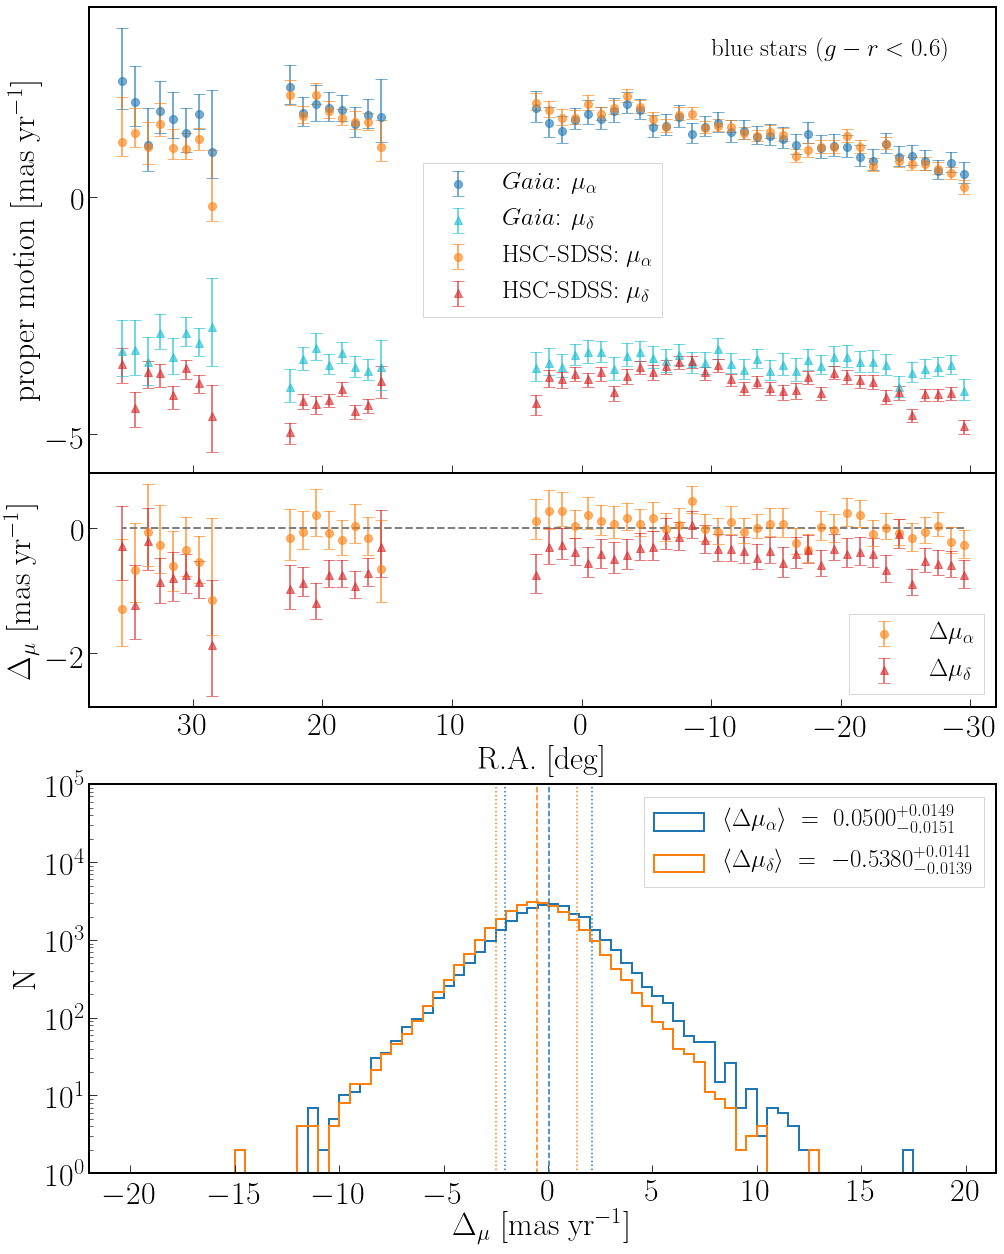

In [266]:
plt.figure(figsize=(14,18))
ax=plt.axes([0.05,0.59,0.9,0.36])
#plt.title(r'$\mu_\alpha$ and $\mu_\delta$ versus R.A. by stars matched with Gaia')
#plt.hlines(np.mean(mss.dra_cl),np.min(xm),np.max(xm),color='darkblue')
#plt.hlines(np.mean(mss.ddec_cl),np.min(xm),np.max(xm),color='darkred')
#plt.plot(xm,np.array(ram),color='darkblue')
#plt.plot(xm,np.array(decm),color='darkred')
plt.errorbar(x1Bin1,m1edianBin1,s1igGbin1,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:blue',label=r'$Gaia$: $\mu_\alpha$')
plt.errorbar(x1Bin11,m1edianBin11,s1igGbin11,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:cyan',label=r'$Gaia$: $\mu_\delta$')
#plt.plot(xm,ram3,color='cyan')
#plt.plot(xm,decm3,color='pink')
plt.errorbar(x1Bin2,m1edianBin2,s1igGbin2,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:orange',label=r'HSC-SDSS: $\mu_\alpha$')
plt.errorbar(x1Bin21,m1edianBin21,s1igGbin21,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:red',label=r'HSC-SDSS: $\mu_\delta$')
plt.legend()
plt.text(-10,3,'blue stars ($g-r<0.6$)')
plt.xlim(38,-32)
ax.yaxis.set_major_locator(MultipleLocator(5))
plt.ylabel('proper motion [$\mathrm{mas\ yr^{-1}}$]',fontsize=32)
ax=plt.axes([0.05,0.41,0.9,0.18])
plt.errorbar(x1Bin3,m1edianBin3,s1igGbin3,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:orange',label=r'$\Delta\mu_\alpha$')
plt.errorbar(x1Bin31,m1edianBin31,s1igGbin31,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:red',label=r'$\Delta\mu_\delta$')
plt.hlines(0,min(x1Bin1),max(x1Bin1),color='grey',linestyle='dashed')
plt.legend()
plt.xlim(38,-32)
plt.xlabel('R.A. [deg]')
plt.ylabel('$\Delta_\mu$ [$\mathrm{mas\ yr^{-1}}$]',fontsize=32)

ax=plt.axes([0.05,0.05,0.9,0.3])
plt.hist(pmra3,bins=np.arange(-20,20,0.5),linewidth=2,histtype='step',color='tab:blue',label=r'$\langle \Delta\mu_{\alpha}\rangle \ =\ %0.4f^{+%0.4f}_{-%0.4f}$'%(np.median(pmra3),sig1(pmra3.values),sig2(pmra3.values)))#,np.std(g.pmra_2-g.pmra_cl)))
plt.vlines(np.median(pmra3),0,1e5,linewidth=1.5,linestyles='dashed',color='tab:blue')
plt.hist(pmdec3,bins=np.arange(-20,20,0.5),linewidth=2,histtype='step',color='tab:orange',label=r'$\langle \Delta\mu_{\delta}\rangle \ =\ %0.4f^{+%0.4f}_{-%0.4f}$'%(np.median(pmdec3),sig1(pmdec3.values),sig2(pmdec3.values)))#,np.std(g.pmdec_2-g.pmdec_cl)))
plt.vlines(np.median(pmdec3),0,1e5,linewidth=1.5,linestyles='dashed',color='tab:orange')
plt.vlines(np.percentile(pmra3,16),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:blue')
plt.vlines(np.percentile(pmra3,84),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:blue')
plt.vlines(np.percentile(pmdec3,16),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:orange')
plt.vlines(np.percentile(pmdec3,84),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:orange')
plt.yscale('log')
plt.ylim([1,1e5])
plt.ylabel('N',fontsize=32)
plt.xlabel(r'$\Delta_\mu\ [\mathrm{mas\ yr^{-1}}]$',fontsize=32)
plt.legend()
plt.savefig('/Users/tianqiu/Documents/final/newgaia/gaia_blue.pdf')

In [267]:
t=g[g.gr>0.6]
ra=t.i_sdsscentroid_ra
pmra1=t.pmra_2
pmra2=t.pmra_cl
pmra3=t.pmra_cl-t.pmra_2
pmdec1=t.pmdec_2
pmdec2=t.pmdec_cl
pmdec3=t.pmdec_cl-t.pmdec_2

x1Bin1, n1Pts1, m1edianBin1, s1igGbin1 = fitMedians(ra, pmra1, -30, 36, 66, 0)#gaia
x1Bin2, n1Pts2, m1edianBin2, s1igGbin2 = fitMedians(ra, pmra2, -30, 36, 66, 0)#HSC-S82
#difference
s1igGbin3=s1igGbin1
x1Bin3 = x1Bin1
m1edianBin3=m1edianBin2-m1edianBin1
s1igGbin3[0]=np.sqrt(s1igGbin2[0]**2+s1igGbin1[1]**2)
s1igGbin3[1]=np.sqrt(s1igGbin2[1]**2+s1igGbin1[0]**2)

x1Bin11, n1Pts11, m1edianBin11, s1igGbin11 = fitMedians(ra, pmdec1, -30, 36, 66, 0)
x1Bin21, n1Pts21, m1edianBin21, s1igGbin21 = fitMedians(ra, pmdec2, -30, 36, 66, 0)
#difference
x1Bin31 = x1Bin11
s1igGbin31=s1igGbin11
m1edianBin31=m1edianBin21-m1edianBin11
s1igGbin31[0]=np.sqrt(s1igGbin21[0]**2+s1igGbin11[1]**2)
s1igGbin31[1]=np.sqrt(s1igGbin21[1]**2+s1igGbin11[0]**2)
    

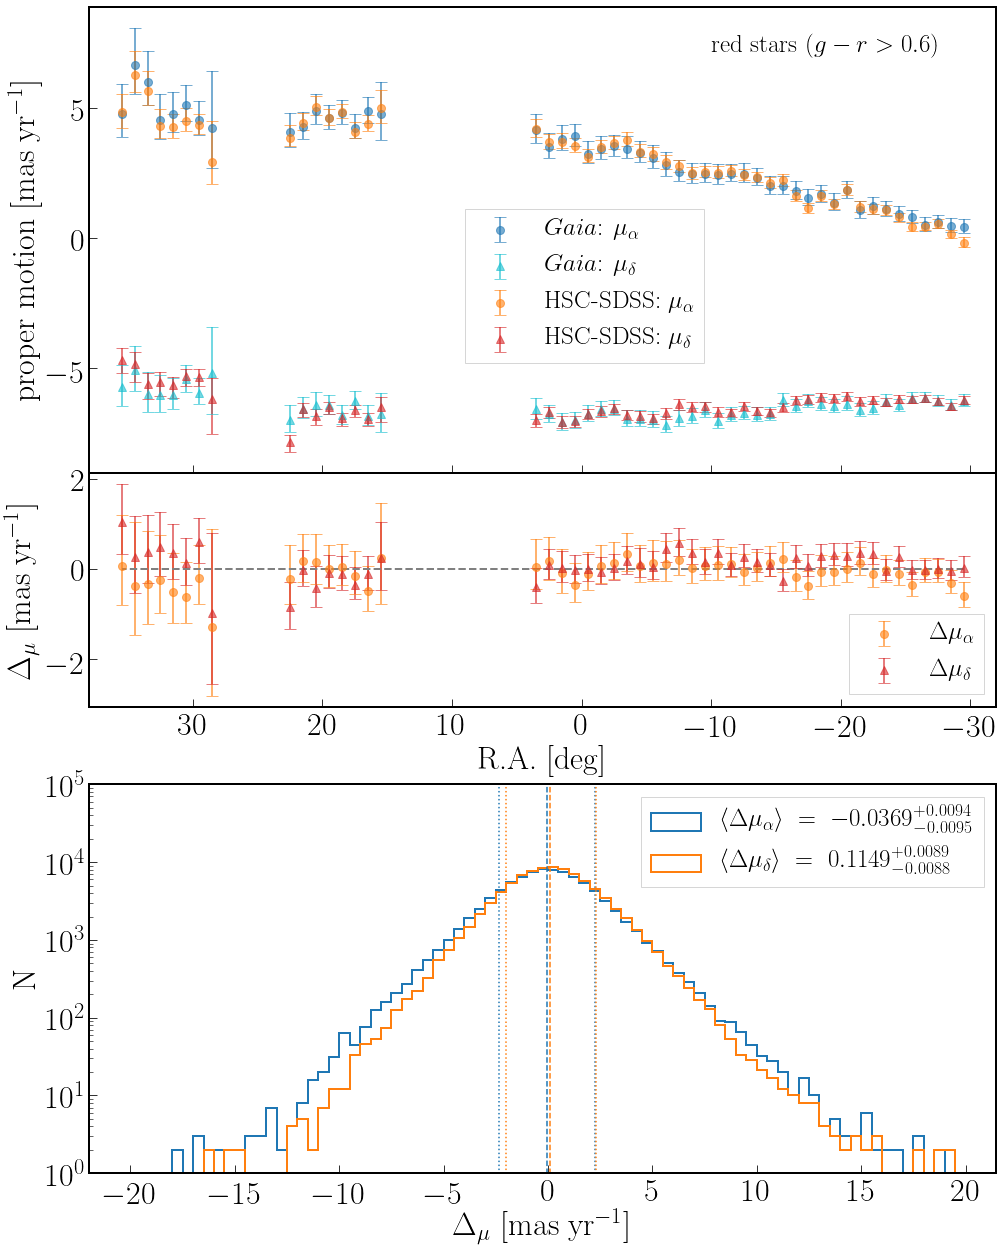

In [268]:
plt.figure(figsize=(14,18))
ax=plt.axes([0.05,0.59,0.9,0.36])
#plt.title(r'$\mu_\alpha$ and $\mu_\delta$ versus R.A. by stars matched with Gaia')
#plt.hlines(np.mean(mss.dra_cl),np.min(xm),np.max(xm),color='darkblue')
#plt.hlines(np.mean(mss.ddec_cl),np.min(xm),np.max(xm),color='darkred')
#plt.plot(xm,np.array(ram),color='darkblue')
#plt.plot(xm,np.array(decm),color='darkred')
plt.errorbar(x1Bin1,m1edianBin1,s1igGbin1,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:blue',label=r'$Gaia$: $\mu_\alpha$')
plt.errorbar(x1Bin11,m1edianBin11,s1igGbin11,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:cyan',label=r'$Gaia$: $\mu_\delta$')
#plt.plot(xm,ram3,color='cyan')
#plt.plot(xm,decm3,color='pink')
plt.errorbar(x1Bin2,m1edianBin2,s1igGbin2,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:orange',label=r'HSC-SDSS: $\mu_\alpha$')
plt.errorbar(x1Bin21,m1edianBin21,s1igGbin21,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:red',label=r'HSC-SDSS: $\mu_\delta$')
plt.legend(bbox_to_anchor=(0.4,0.21))
plt.text(-10,7.2,'red stars ($g-r>0.6$)')
plt.xlim(38,-32)
ax.yaxis.set_major_locator(MultipleLocator(5))
plt.ylabel('proper motion [$\mathrm{mas\ yr^{-1}}$]',fontsize=32)
ax=plt.axes([0.05,0.41,0.9,0.18])
plt.errorbar(x1Bin3,m1edianBin3,s1igGbin3,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:orange',label=r'$\Delta\mu_\alpha$')
plt.errorbar(x1Bin31,m1edianBin31,s1igGbin31,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:red',label=r'$\Delta\mu_\delta$')
plt.hlines(0,min(x1Bin1),max(x1Bin1),color='grey',linestyle='dashed')
plt.legend()
plt.xlim(38,-32)
plt.xlabel('R.A. [deg]')
plt.ylabel('$\Delta_\mu$ [$\mathrm{mas\ yr^{-1}}$]',fontsize=32)

ax=plt.axes([0.05,0.05,0.9,0.3])
plt.hist(pmra3,bins=np.arange(-20,20,0.5),linewidth=2,histtype='step',color='tab:blue',label=r'$\langle \Delta\mu_{\alpha}\rangle \ =\ %0.4f^{+%0.4f}_{-%0.4f}$'%(np.median(pmra3),sig1(pmra3.values),sig2(pmra3.values)))#,np.std(g.pmra_2-g.pmra_cl)))
plt.vlines(np.median(pmra3),0,1e5,linewidth=1.5,linestyles='dashed',color='tab:blue')
plt.hist(pmdec3,bins=np.arange(-20,20,0.5),linewidth=2,histtype='step',color='tab:orange',label=r'$\langle \Delta\mu_{\delta}\rangle \ =\ %0.4f^{+%0.4f}_{-%0.4f}$'%(np.median(pmdec3),sig1(pmdec3.values),sig2(pmdec3.values)))#,np.std(g.pmdec_2-g.pmdec_cl)))
plt.vlines(np.median(pmdec3),0,1e5,linewidth=1.5,linestyles='dashed',color='tab:orange')
plt.vlines(np.percentile(pmra3,16),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:blue')
plt.vlines(np.percentile(pmra3,84),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:blue')
plt.vlines(np.percentile(pmdec3,16),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:orange')
plt.vlines(np.percentile(pmdec3,84),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:orange')
plt.yscale('log')
plt.ylim([1,1e5])
plt.ylabel('N',fontsize=32)
plt.xlabel(r'$\Delta_\mu\ [\mathrm{mas\ yr^{-1}}]$',fontsize=32)
plt.legend()
plt.savefig('/Users/tianqiu/Documents/final/newgaia/gaia_red.pdf')

## some statistic

In [269]:
t=g.sort_values('phot_g_mean_mag')

In [270]:
len(t.iloc[:10000]),np.median(t.iloc[:10000].pmra_error),np.median(t.iloc[:10000].pmdec_error),np.median(t.iloc[:10000].pmra_err),np.median(t.iloc[:10000].pmdec_err)

(10000,
 0.5696863130886742,
 0.3980854260148182,
 0.09740391745429312,
 0.09624691644321687)

In [271]:
len(t.iloc[-10000:]),np.median(t.iloc[-10000:].pmra_error),np.median(t.iloc[-10000:].pmdec_error),np.median(t.iloc[-10000:].pmra_err),np.median(t.iloc[-10000:].pmdec_err)

(10000,
 2.924349872617218,
 2.3955397164058922,
 0.5173113616829582,
 0.5027503717990837)

In [272]:
len(g),np.median(g.pmra_error),np.median(g.pmdec_error),np.median(g.pmra_err),np.median(g.pmdec_err)

(117703,
 1.3692499211525972,
 1.101773515027615,
 0.2767058714708461,
 0.2699723351805936)

In [273]:
t=g[(g.phot_g_mean_mag>20)&(g.phot_g_mean_mag<21)]

In [274]:
len(t),np.median(t.pmra_error),np.median(t.pmdec_error),np.median(t.pmra_err),np.median(t.pmdec_err)

(57648,
 1.9374562679900693,
 1.5820263324736732,
 0.3920224442841177,
 0.381710012894321)

## DCR color

In [93]:
gb=g[g.gr<0.6]
gr=g[g.gr>0.6]

Text(30, 1.45, 'red stars in $Gaia$')

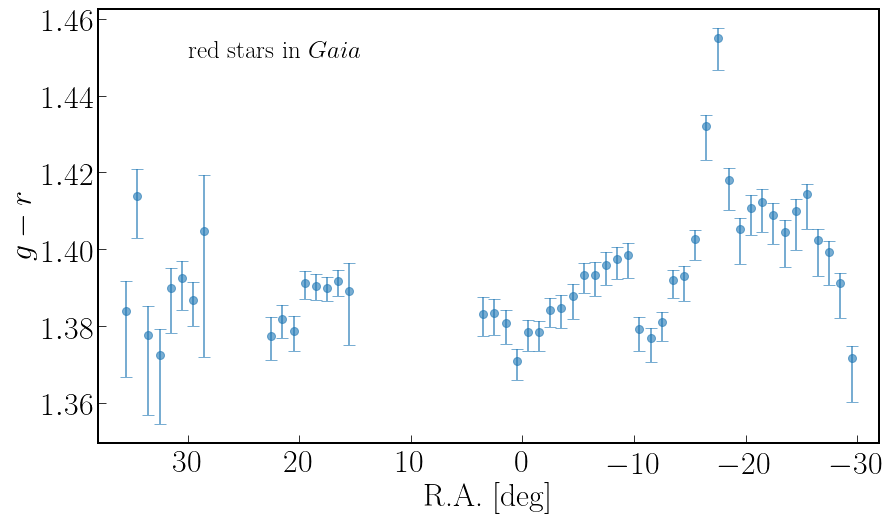

In [129]:
plt.figure(figsize=(14,8))
x1Bin1, n1Pts1, m1edianBin1, s1igGbin1 = fitMedians(gr.i_sdsscentroid_ra, gr.gr, -30, 36, 66, 0)
plt.errorbar(x1Bin1,m1edianBin1,s1igGbin1,fmt='o',capsize=6,markersize=8,alpha=0.6)
plt.xlim(38,-32)
plt.xlabel('R.A. [deg]')
plt.ylabel('$g-r$')
plt.text(30,1.45,'red stars in $Gaia$')
#plt.savefig('../Documents/final/DCRtestGaia/colorred.pdf')

Text(0, 0.5, '$g-i$')

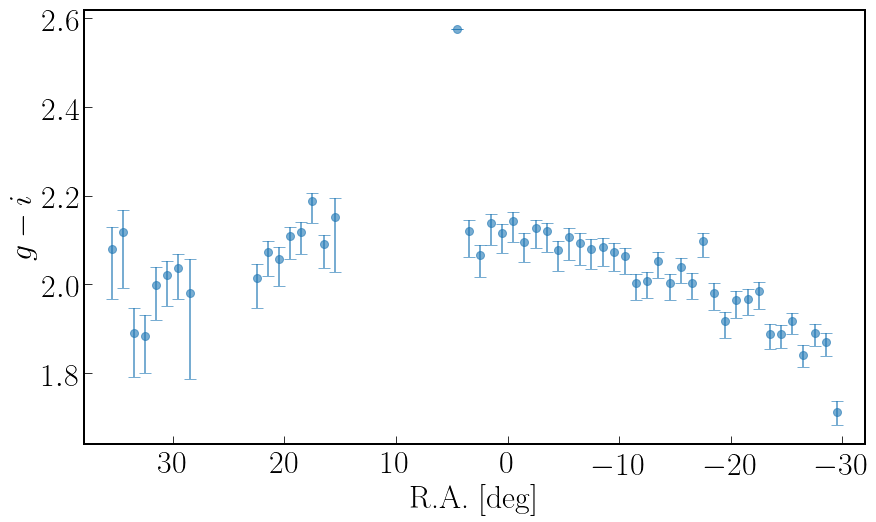

In [130]:
plt.figure(figsize=(14,8))
x1Bin1, n1Pts1, m1edianBin1, s1igGbin1 = fitMedians(g.i_sdsscentroid_ra, g.gi, -30, 36, 66, 0)
plt.errorbar(x1Bin1,m1edianBin1,s1igGbin1,fmt='o',capsize=6,markersize=8,alpha=0.6)
plt.xlim(38,-32)
plt.xlabel('R.A. [deg]')
plt.ylabel('$g-i$')
#plt.text(30,0.43,'blue stars in $Gaia$')
#plt.savefig('../Documents/final/DCRtestGaia/colorblue.pdf')

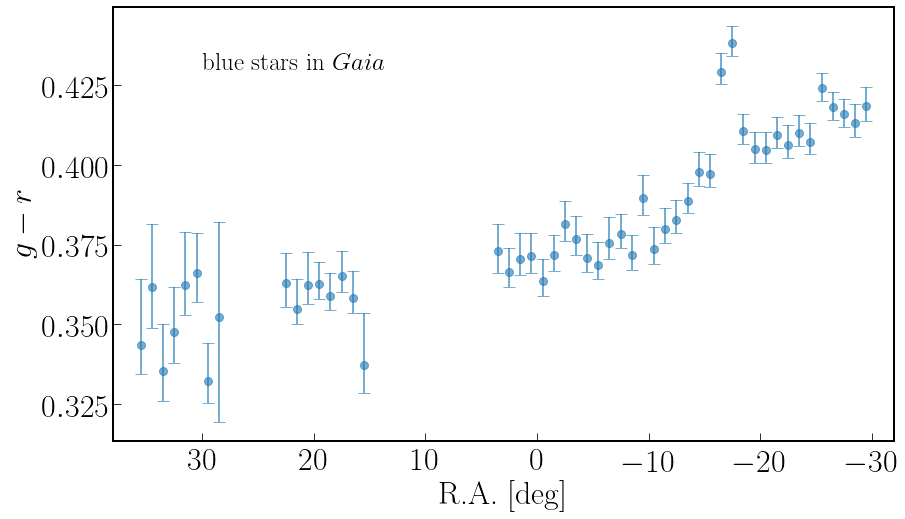

In [65]:
plt.figure(figsize=(14,8))
x1Bin1, n1Pts1, m1edianBin1, s1igGbin1 = fitMedians(gb.i_sdsscentroid_ra, gb.gr, -30, 36, 66, 0)
plt.errorbar(x1Bin1,m1edianBin1,s1igGbin1,fmt='o',capsize=6,markersize=8,alpha=0.6)
plt.xlim(38,-32)
plt.xlabel('R.A. [deg]')
plt.ylabel('$g-r$')
plt.text(30,0.43,'blue stars in $Gaia$')
plt.savefig('../Documents/final/DCRtestGaia/colorblue.pdf')

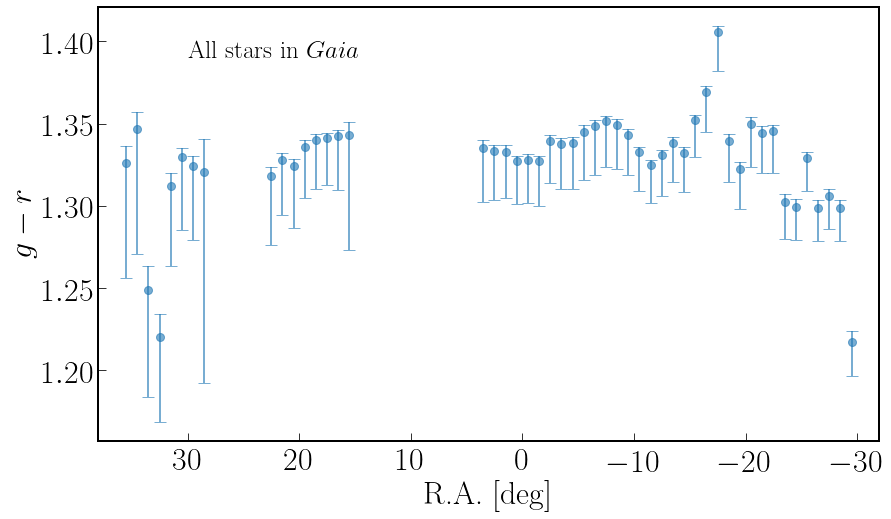

In [116]:
plt.figure(figsize=(14,8))
x1Bin1, n1Pts1, m1edianBin1, s1igGbin1 = fitMedians(g.i_sdsscentroid_ra, g.gr, -30, 36, 66, 0)
plt.errorbar(x1Bin1,m1edianBin1,s1igGbin1,fmt='o',capsize=6,markersize=8,alpha=0.6)
plt.xlim(38,-32)
plt.xlabel('R.A. [deg]')
plt.ylabel('$g-r$')
plt.text(30,1.39,'All stars in $Gaia$')
plt.savefig('../Documents/final/DCRtestGaia/colorall.pdf')

In [111]:
len(g[g.gr>1.8])/len(g)

0.0013917766368226757

In [125]:
len(g[g.gi>4])/len(g)

0.0011202009572626361

In [112]:
g=g[g.gr<1.8]

In [113]:
len(g)

117671

In [ ]:
def dcr(x,b,k):
    return k*x+b

In [86]:
popt1, pcov1 =curve_fit(dcr,g[g.gr<1.6].gr,g[g.gr<1.6].pmra_cl-g[g.gr<1.6].pmra_2)

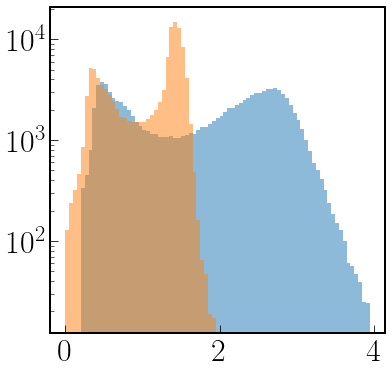

In [146]:
plt.hist(g.gi,bins=np.arange(0,4,0.05),alpha=0.5)
plt.hist(g.gr,bins=np.arange(0,2,0.05),alpha=0.5)
plt.yscale('log')

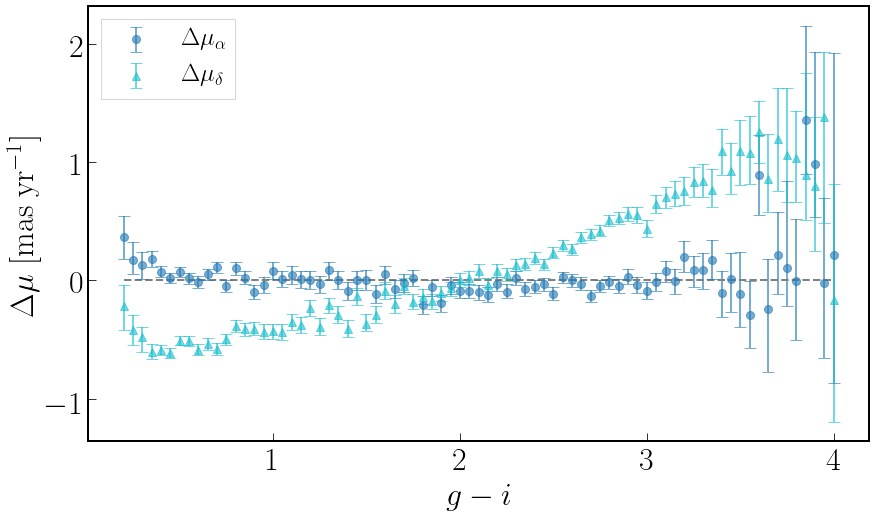

In [321]:
plt.figure(figsize=(14,8))
x1Bin1, n1Pts1, m1edianBin1, s1igGbin1 = fitMedians(g.gi, g.pmra_cl-g.pmra_2, 0.175, 4.025, 77, 0)
plt.errorbar(x1Bin1,m1edianBin1,s1igGbin1,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:blue',label=r'$\Delta\mu_\alpha$')
#popt1, pcov1 =curve_fit(dcr,g[g.gr<1.6].gr,g[g.gr<1.6].pmra_cl-g[g.gr<1.6].pmra_2)
#x=np.arange(0.2,1.7,0.1)
#plt.plot(x,dcr(x,*popt1),color='tab:orange',label=r'$y=$'+str(round(popt1[0],4))+'$+$'+str(round(popt1[1],4))+'$x$')
x1Bin1, n1Pts1, m1edianBin1, s1igGbin1 = fitMedians(g.gi, g.pmdec_cl-g.pmdec_2, 0.175, 4.025, 77, 0)
plt.errorbar(x1Bin1,m1edianBin1,s1igGbin1,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:cyan',label=r'$\Delta\mu_\delta$')
#popt1, pcov1 =curve_fit(dcr,g[g.gr<1.6].gr,g[g.gr<1.6].pmdec_cl-g[g.gr<1.6].pmdec_2)
#x=np.arange(0.2,1.7,0.1)
#plt.plot(x,dcr(x,*popt1),color='tab:red',label=r'$y=$'+str(round(popt1[0],4))+'$+$'+str(round(popt1[1],4))+'$x$')
plt.ylabel('$\Delta\mu$ [mas yr$^{-1}$]')
plt.xlabel('$g-i$')
plt.legend()
plt.hlines(0,0.2,4,linestyle='dashed',color='grey')
#plt.text(30,0.43,'blue stars in $Gaia$')
plt.savefig('../Documents/final/DCRtestGaia/deltamu_gi.pdf')

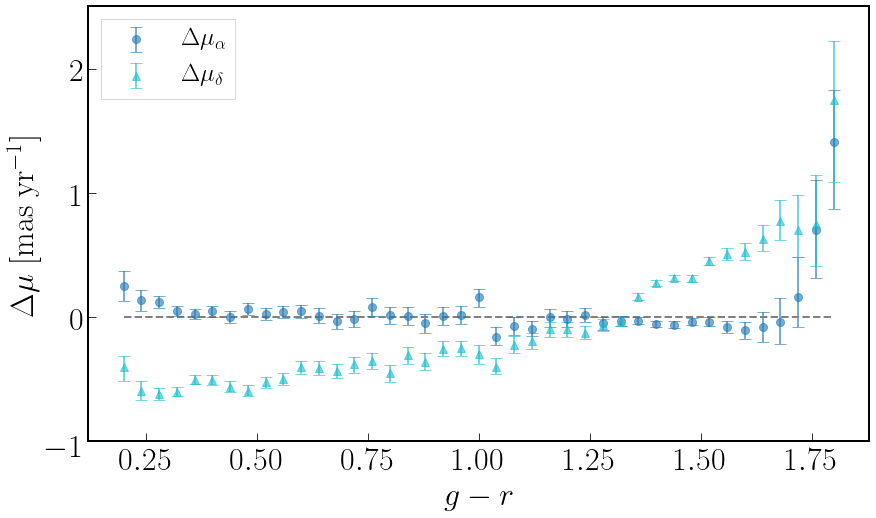

In [323]:
plt.figure(figsize=(14,8))
x1Bin1, n1Pts1, m1edianBin1, s1igGbin1 = fitMedians(g.gr, g.pmra_cl-g.pmra_2, 0.18, 1.82, 41, 0)
plt.errorbar(x1Bin1,m1edianBin1,s1igGbin1,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:blue',label=r'$\Delta\mu_\alpha$')
#popt1, pcov1 =curve_fit(dcr,g[g.gr<1.6].gr,g[g.gr<1.6].pmra_cl-g[g.gr<1.6].pmra_2)
#x=np.arange(0.2,1.7,0.1)
#plt.plot(x,dcr(x,*popt1),color='tab:orange',label=r'$y=$'+str(round(popt1[0],4))+'$+$'+str(round(popt1[1],4))+'$x$')
x1Bin1, n1Pts1, m1edianBin1, s1igGbin1 = fitMedians(g.gr, g.pmdec_cl-g.pmdec_2, 0.18, 1.82, 41, 0)
plt.errorbar(x1Bin1,m1edianBin1,s1igGbin1,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:cyan',label=r'$\Delta\mu_\delta$')
#popt1, pcov1 =curve_fit(dcr,g[g.gr<1.6].gr,g[g.gr<1.6].pmdec_cl-g[g.gr<1.6].pmdec_2)
#x=np.arange(0.2,1.7,0.1)
#plt.plot(x,dcr(x,*popt1),color='tab:red',label=r'$y=$'+str(round(popt1[0],4))+'$+$'+str(round(popt1[1],4))+'$x$')
plt.ylabel('$\Delta\mu$ [mas yr$^{-1}$]')
plt.xlabel('$g-r$')
plt.ylim(-1,2.5)
plt.hlines(0,0.2,1.8,linestyle='dashed',color='grey')
plt.legend()
#plt.text(30,0.43,'blue stars in $Gaia$')
plt.savefig('../Documents/final/DCRtestGaia/deltamu_gr.pdf')

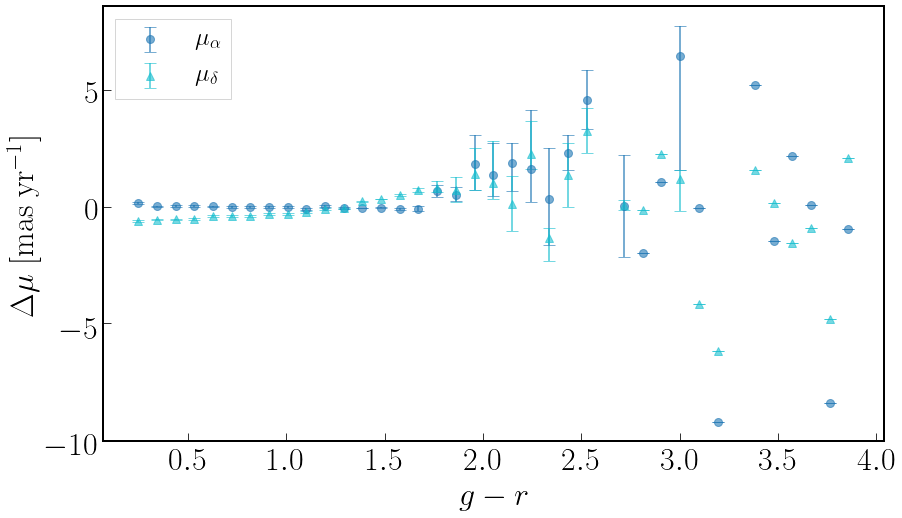

In [84]:
plt.figure(figsize=(14,8))
x1Bin1, n1Pts1, m1edianBin1, s1igGbin1 = fitMedians(g.gr, g.pmra_cl-g.pmra_2, 0.2, 4, 40, 0)
plt.errorbar(x1Bin1,m1edianBin1,s1igGbin1,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:blue',label=r'$\mu_\alpha$')
x1Bin1, n1Pts1, m1edianBin1, s1igGbin1 = fitMedians(g.gr, g.pmdec_cl-g.pmdec_2, 0.2, 4, 40, 0)
plt.errorbar(x1Bin1,m1edianBin1,s1igGbin1,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:cyan',label=r'$\mu_\delta$')
plt.ylabel('$\Delta\mu$ [mas yr$^{-1}$]')
plt.xlabel('$g-r$')
plt.legend()
#plt.text(30,0.43,'blue stars in $Gaia$')
plt.savefig('../Documents/final/DCRtestGaia/deltamu2.pdf')

# Interpolation

In [156]:
len(g[g.gi>3.5])/len(g)

0.006636342034692285

In [13]:
def inter(x,a,b):
    return (b-a)/0.05*x+a

In [13]:
x1Bin1, n1Pts1, m1edianBin1, s1igGbin1 = fitMedians(g.gi, g.pmra_cl-g.pmra_2, 0.175, 4.025, 77, 0)
x1Bin2, n1Pts2, m1edianBin2, s1igGbin2 = fitMedians(g.gi, g.pmdec_cl-g.pmdec_2, 0.175, 4.025, 77, 0)

## for gaia matched stars 

In [12]:
tt=[]
for i in range(len(x1Bin1)-1):
    t=g[(g.gi>x1Bin1[i])&(g.gi<x1Bin1[i+1])]
    t['pmra_cl3']=t.pmra_cl-inter(t.gi-x1Bin1[i],m1edianBin1[i],m1edianBin1[i+1])
    t['pmdec_cl3']=t.pmdec_cl-inter(t.gi-x1Bin2[i],m1edianBin2[i],m1edianBin2[i+1])
    tt.append(t)

NameError: name 'x1Bin1' is not defined

In [293]:
ttt=pd.concat(tt)

In [294]:
len(ttt)

117703

In [304]:
g=ttt

In [14]:
t=g#[ttt.gr<0.6]
ra=t.i_sdsscentroid_ra
pmra1=t.pmra_2
pmra2=t.pmra_cl3
pmra3=t.pmra_cl3-t.pmra_2
pmdec1=t.pmdec_2
pmdec2=t.pmdec_cl3
pmdec3=t.pmdec_cl3-t.pmdec_2

x1Bin1, n1Pts1, m1edianBin1, s1igGbin1 = fitMedians(ra, pmra1, -30, 36, 66, 0)#gaia
x1Bin2, n1Pts2, m1edianBin2, s1igGbin2 = fitMedians(ra, pmra2, -30, 36, 66, 0)#HSC-S82
#difference
s1igGbin3=s1igGbin1
x1Bin3 = x1Bin1
m1edianBin3=m1edianBin2-m1edianBin1
s1igGbin3[0]=np.sqrt(s1igGbin2[0]**2+s1igGbin1[1]**2)
s1igGbin3[1]=np.sqrt(s1igGbin2[1]**2+s1igGbin1[0]**2)

x1Bin11, n1Pts11, m1edianBin11, s1igGbin11 = fitMedians(ra, pmdec1, -30, 36, 66, 0)
x1Bin21, n1Pts21, m1edianBin21, s1igGbin21 = fitMedians(ra, pmdec2, -30, 36, 66, 0)
#difference
x1Bin31 = x1Bin11
s1igGbin31=s1igGbin11
m1edianBin31=m1edianBin21-m1edianBin11
s1igGbin31[0]=np.sqrt(s1igGbin21[0]**2+s1igGbin11[1]**2)
s1igGbin31[1]=np.sqrt(s1igGbin21[1]**2+s1igGbin11[0]**2)
    

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


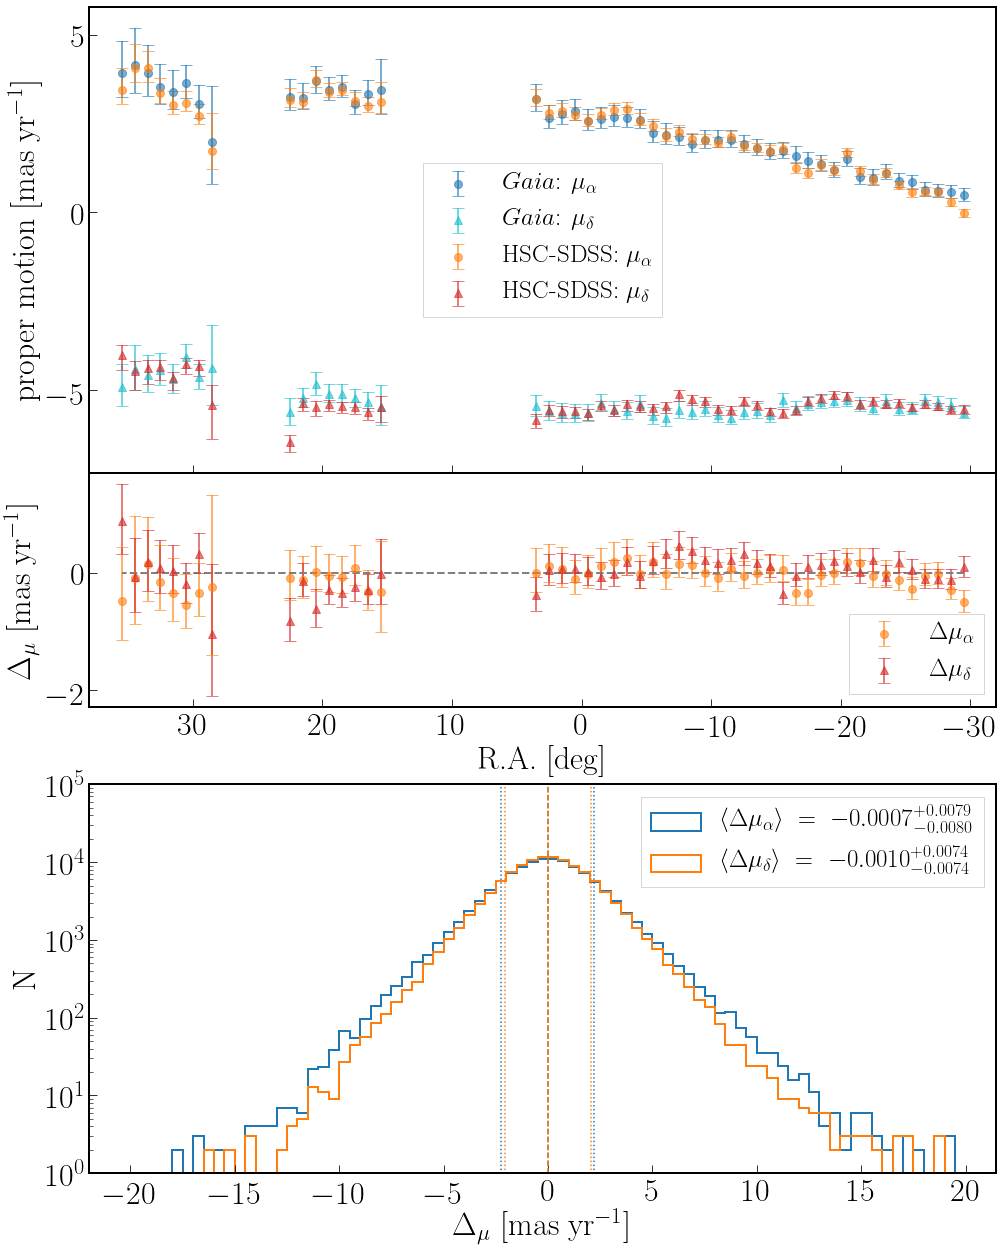

In [15]:
plt.figure(figsize=(14,18))
ax=plt.axes([0.05,0.59,0.9,0.36])
#plt.title(r'$\mu_\alpha$ and $\mu_\delta$ versus R.A. by stars matched with Gaia')
#plt.hlines(np.mean(mss.dra_cl),np.min(xm),np.max(xm),color='darkblue')
#plt.hlines(np.mean(mss.ddec_cl),np.min(xm),np.max(xm),color='darkred')
#plt.plot(xm,np.array(ram),color='darkblue')
#plt.plot(xm,np.array(decm),color='darkred')
plt.errorbar(x1Bin1,m1edianBin1,s1igGbin1,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:blue',label=r'$Gaia$: $\mu_\alpha$')
plt.errorbar(x1Bin11,m1edianBin11,s1igGbin11,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:cyan',label=r'$Gaia$: $\mu_\delta$')
#plt.plot(xm,ram3,color='cyan')
#plt.plot(xm,decm3,color='pink')
plt.errorbar(x1Bin2,m1edianBin2,s1igGbin2,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:orange',label=r'HSC-SDSS: $\mu_\alpha$')
plt.errorbar(x1Bin21,m1edianBin21,s1igGbin21,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:red',label=r'HSC-SDSS: $\mu_\delta$')
plt.legend(loc=10)
plt.xlim(38,-32)
#plt.text(-10,3,'blue stars ($g-r<0.6$)')
ax.yaxis.set_major_locator(MultipleLocator(5))
plt.ylabel('proper motion [$\mathrm{mas\ yr^{-1}}$]',fontsize=32)
ax=plt.axes([0.05,0.41,0.9,0.18])
plt.errorbar(x1Bin3,m1edianBin3,s1igGbin3,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:orange',label=r'$\Delta\mu_\alpha$')
plt.errorbar(x1Bin31,m1edianBin31,s1igGbin31,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:red',label=r'$\Delta\mu_\delta$')
plt.hlines(0,min(x1Bin1),max(x1Bin1),color='grey',linestyle='dashed')
plt.legend()
plt.xlim(38,-32)
plt.xlabel('R.A. [deg]')
plt.ylabel('$\Delta_\mu$ [$\mathrm{mas\ yr^{-1}}$]',fontsize=32)


ax=plt.axes([0.05,0.05,0.9,0.3])
plt.hist(pmra3,bins=np.arange(-20,20,0.5),linewidth=2,histtype='step',color='tab:blue',label=r'$\langle \Delta\mu_{\alpha}\rangle \ = \ %0.4f^{+%0.4f}_{-%0.4f}$'\
         %(np.median(pmra3),sig1(pmra3.values),sig2(pmra3.values)))#,np.std(g.pmra_2-g.pmra_cl)))
plt.vlines(np.median(pmra3),0,1e5,linewidth=1.5,linestyles='dashed',color='tab:blue')
plt.hist(pmdec3,bins=np.arange(-20,20,0.5),linewidth=2,histtype='step',color='tab:orange',label=r'$\langle \Delta\mu_{\delta}\rangle\ =\ %0.4f^{+%0.4f}_{-%0.4f}$'\
         %(np.median(pmdec3),sig1(pmdec3.values),sig2(pmdec3.values)))#,np.std(g.pmdec_2-g.pmdec_cl)))
plt.vlines(np.median(pmdec3),0,1e5,linewidth=1.5,linestyles='dashed',color='tab:orange')
plt.vlines(np.percentile(pmra3,16),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:blue')
plt.vlines(np.percentile(pmra3,84),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:blue')
plt.vlines(np.percentile(pmdec3,16),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:orange')
plt.vlines(np.percentile(pmdec3,84),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:orange')
plt.yscale('log')
plt.ylim([1,1e5])
plt.ylabel('N',fontsize=32)
plt.xlabel(r'$\Delta_\mu\ [\mathrm{mas\ yr^{-1}}]$',fontsize=32)
plt.legend()
plt.savefig('/Users/tianqiu/Documents/final/newgaia/gaia_all_dcr.pdf')

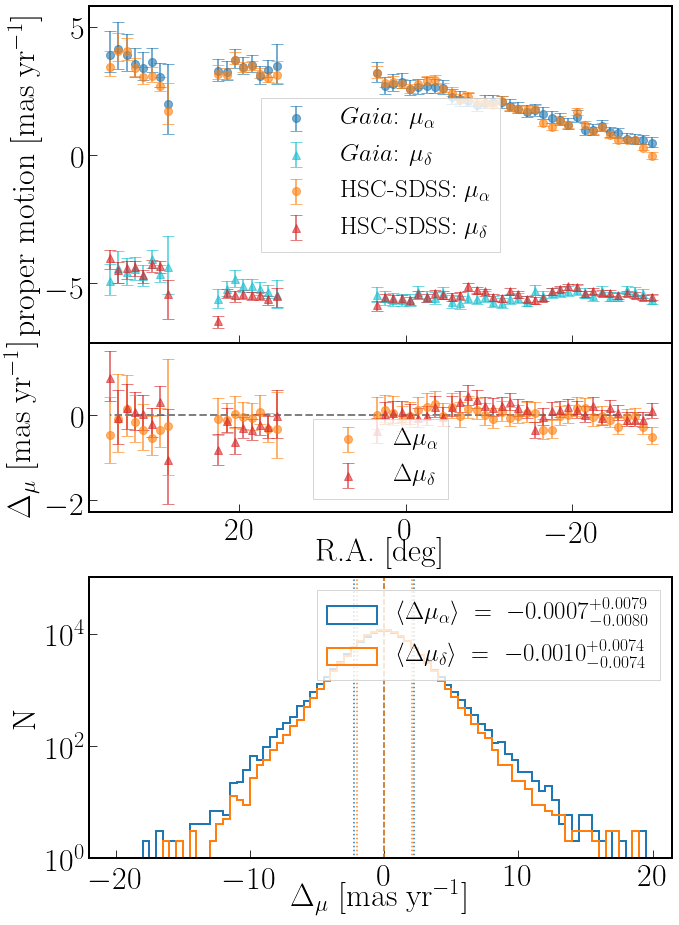

In [21]:
plt.figure(figsize=(9,13))
ax=plt.axes([0.05,0.60,0.9,0.36])
#plt.title(r'$\mu_\alpha$ and $\mu_\delta$ versus R.A. by stars matched with Gaia')
#plt.hlines(np.mean(mss.dra_cl),np.min(xm),np.max(xm),color='darkblue')
#plt.hlines(np.mean(mss.ddec_cl),np.min(xm),np.max(xm),color='darkred')
#plt.plot(xm,np.array(ram),color='darkblue')
#plt.plot(xm,np.array(decm),color='darkred')
plt.errorbar(x1Bin1,m1edianBin1,s1igGbin1,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:blue',label=r'$Gaia$: $\mu_\alpha$')
plt.errorbar(x1Bin11,m1edianBin11,s1igGbin11,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:cyan',label=r'$Gaia$: $\mu_\delta$')
#plt.plot(xm,ram3,color='cyan')
#plt.plot(xm,decm3,color='pink')
plt.errorbar(x1Bin2,m1edianBin2,s1igGbin2,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:orange',label=r'HSC-SDSS: $\mu_\alpha$')
plt.errorbar(x1Bin21,m1edianBin21,s1igGbin21,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:red',label=r'HSC-SDSS: $\mu_\delta$')
plt.legend(loc=10)
plt.xlim(38,-32)
#plt.text(-10,3,'blue stars ($g-r<0.6$)')
ax.yaxis.set_major_locator(MultipleLocator(5))
plt.ylabel('proper motion [$\mathrm{mas\ yr^{-1}}$]',fontsize=32)
ax=plt.axes([0.05,0.42,0.9,0.18])
plt.errorbar(x1Bin3,m1edianBin3,s1igGbin3,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:orange',label=r'$\Delta\mu_\alpha$')
plt.errorbar(x1Bin31,m1edianBin31,s1igGbin31,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:red',label=r'$\Delta\mu_\delta$')
plt.hlines(0,min(x1Bin1),max(x1Bin1),color='grey',linestyle='dashed')
plt.legend()
plt.xlim(38,-32)
plt.xlabel('R.A. [deg]',labelpad=-10)
plt.ylabel('$\Delta_\mu$ [$\mathrm{mas\ yr^{-1}}$]',fontsize=32)


ax=plt.axes([0.05,0.05,0.9,0.3])
plt.hist(pmra3,bins=np.arange(-20,20,0.5),linewidth=2,histtype='step',color='tab:blue',label=r'$\langle \Delta\mu_{\alpha}\rangle \ = \ %0.4f^{+%0.4f}_{-%0.4f}$'\
         %(np.median(pmra3),sig1(pmra3.values),sig2(pmra3.values)))#,np.std(g.pmra_2-g.pmra_cl)))
plt.vlines(np.median(pmra3),0,1e5,linewidth=1.5,linestyles='dashed',color='tab:blue')
plt.hist(pmdec3,bins=np.arange(-20,20,0.5),linewidth=2,histtype='step',color='tab:orange',label=r'$\langle \Delta\mu_{\delta}\rangle\ =\ %0.4f^{+%0.4f}_{-%0.4f}$'\
         %(np.median(pmdec3),sig1(pmdec3.values),sig2(pmdec3.values)))#,np.std(g.pmdec_2-g.pmdec_cl)))
plt.vlines(np.median(pmdec3),0,1e5,linewidth=1.5,linestyles='dashed',color='tab:orange')
plt.vlines(np.percentile(pmra3,16),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:blue')
plt.vlines(np.percentile(pmra3,84),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:blue')
plt.vlines(np.percentile(pmdec3,16),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:orange')
plt.vlines(np.percentile(pmdec3,84),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:orange')
plt.yscale('log')
plt.ylim([1,1e5])
plt.ylabel('N',fontsize=32)
plt.xlabel(r'$\Delta_\mu\ [\mathrm{mas\ yr^{-1}}]$',fontsize=32,labelpad=-10)
plt.legend()
plt.savefig('/Users/tianqiu/Documents/gaia.png')

In [298]:
t=ttt[ttt.gr>0.6]
ra=t.i_sdsscentroid_ra
pmra1=t.pmra_2
pmra2=t.pmra_cl3
pmra3=t.pmra_cl3-t.pmra_2
pmdec1=t.pmdec_2
pmdec2=t.pmdec_cl3
pmdec3=t.pmdec_cl3-t.pmdec_2

x1Bin1, n1Pts1, m1edianBin1, s1igGbin1 = fitMedians(ra, pmra1, -30, 36, 66, 0)#gaia
x1Bin2, n1Pts2, m1edianBin2, s1igGbin2 = fitMedians(ra, pmra2, -30, 36, 66, 0)#HSC-S82
#difference
s1igGbin3=s1igGbin1
x1Bin3 = x1Bin1
m1edianBin3=m1edianBin2-m1edianBin1
s1igGbin3[0]=np.sqrt(s1igGbin2[0]**2+s1igGbin1[1]**2)
s1igGbin3[1]=np.sqrt(s1igGbin2[1]**2+s1igGbin1[0]**2)

x1Bin11, n1Pts11, m1edianBin11, s1igGbin11 = fitMedians(ra, pmdec1, -30, 36, 66, 0)
x1Bin21, n1Pts21, m1edianBin21, s1igGbin21 = fitMedians(ra, pmdec2, -30, 36, 66, 0)
#difference
x1Bin31 = x1Bin11
s1igGbin31=s1igGbin11
m1edianBin31=m1edianBin21-m1edianBin11
s1igGbin31[0]=np.sqrt(s1igGbin21[0]**2+s1igGbin11[1]**2)
s1igGbin31[1]=np.sqrt(s1igGbin21[1]**2+s1igGbin11[0]**2)
    

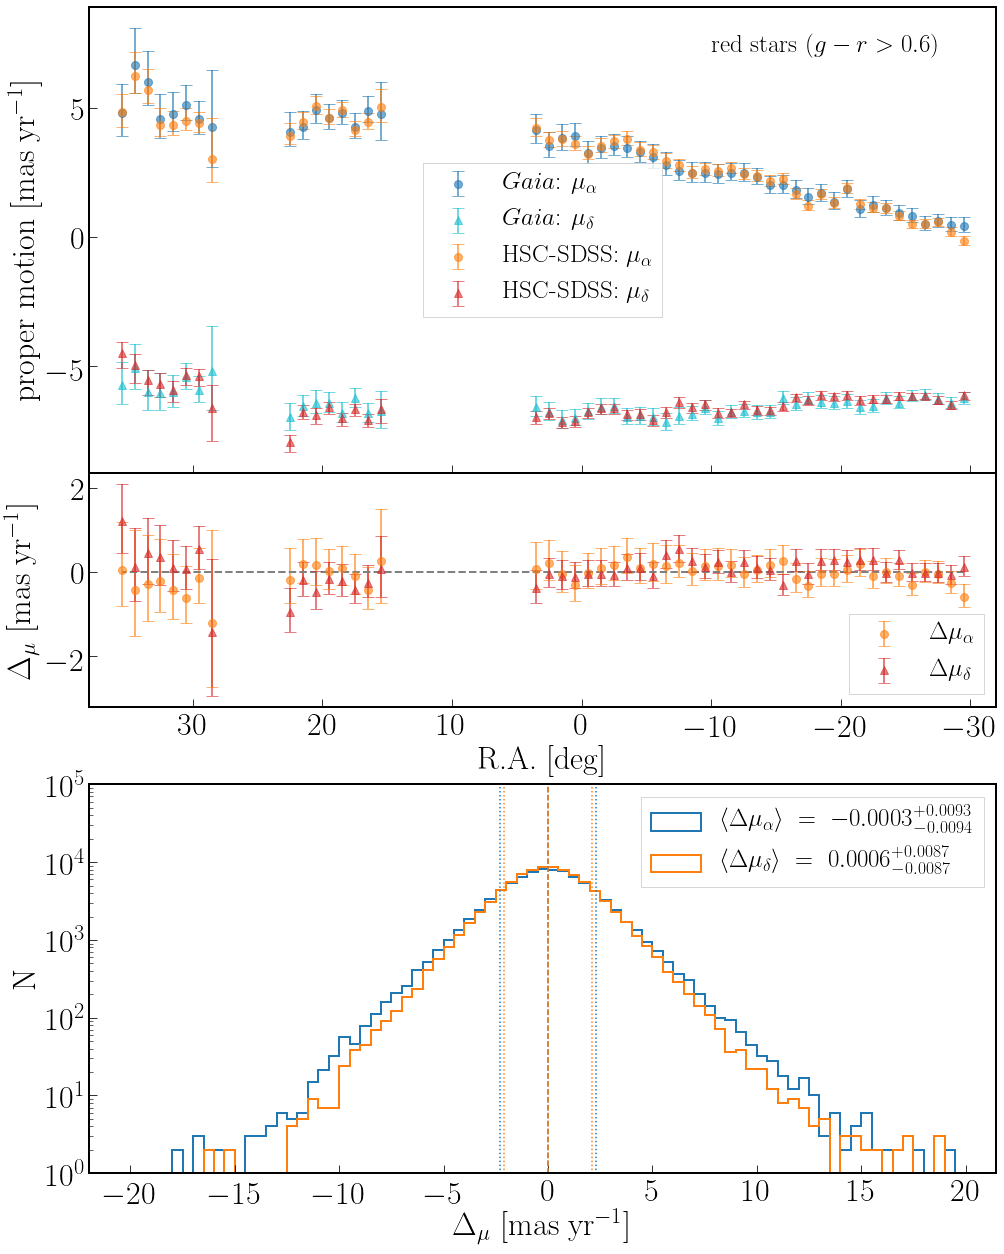

In [299]:
plt.figure(figsize=(14,18))
ax=plt.axes([0.05,0.59,0.9,0.36])
#plt.title(r'$\mu_\alpha$ and $\mu_\delta$ versus R.A. by stars matched with Gaia')
#plt.hlines(np.mean(mss.dra_cl),np.min(xm),np.max(xm),color='darkblue')
#plt.hlines(np.mean(mss.ddec_cl),np.min(xm),np.max(xm),color='darkred')
#plt.plot(xm,np.array(ram),color='darkblue')
#plt.plot(xm,np.array(decm),color='darkred')
plt.errorbar(x1Bin1,m1edianBin1,s1igGbin1,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:blue',label=r'$Gaia$: $\mu_\alpha$')
plt.errorbar(x1Bin11,m1edianBin11,s1igGbin11,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:cyan',label=r'$Gaia$: $\mu_\delta$')
#plt.plot(xm,ram3,color='cyan')
#plt.plot(xm,decm3,color='pink')
plt.errorbar(x1Bin2,m1edianBin2,s1igGbin2,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:orange',label=r'HSC-SDSS: $\mu_\alpha$')
plt.errorbar(x1Bin21,m1edianBin21,s1igGbin21,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:red',label=r'HSC-SDSS: $\mu_\delta$')
plt.legend(loc=10)
plt.xlim(38,-32)
plt.text(-10,7.2,'red stars ($g-r>0.6$)')
ax.yaxis.set_major_locator(MultipleLocator(5))
plt.ylabel('proper motion [$\mathrm{mas\ yr^{-1}}$]',fontsize=32)
ax=plt.axes([0.05,0.41,0.9,0.18])
plt.errorbar(x1Bin3,m1edianBin3,s1igGbin3,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:orange',label=r'$\Delta\mu_\alpha$')
plt.errorbar(x1Bin31,m1edianBin31,s1igGbin31,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:red',label=r'$\Delta\mu_\delta$')
plt.hlines(0,min(x1Bin1),max(x1Bin1),color='grey',linestyle='dashed')
plt.legend()
plt.xlim(38,-32)
plt.xlabel('R.A. [deg]')
plt.ylabel('$\Delta_\mu$ [$\mathrm{mas\ yr^{-1}}$]',fontsize=32)


ax=plt.axes([0.05,0.05,0.9,0.3])
plt.hist(pmra3,bins=np.arange(-20,20,0.5),linewidth=2,histtype='step',color='tab:blue',label=r'$\langle \Delta\mu_{\alpha}\rangle \ = \ %0.4f^{+%0.4f}_{-%0.4f}$'\
         %(np.median(pmra3),sig1(pmra3.values),sig2(pmra3.values)))#,np.std(g.pmra_2-g.pmra_cl)))
plt.vlines(np.median(pmra3),0,1e5,linewidth=1.5,linestyles='dashed',color='tab:blue')
plt.hist(pmdec3,bins=np.arange(-20,20,0.5),linewidth=2,histtype='step',color='tab:orange',label=r'$\langle \Delta\mu_{\delta}\rangle\ =\ %0.4f^{+%0.4f}_{-%0.4f}$'\
         %(np.median(pmdec3),sig1(pmdec3.values),sig2(pmdec3.values)))#,np.std(g.pmdec_2-g.pmdec_cl)))
plt.vlines(np.median(pmdec3),0,1e5,linewidth=1.5,linestyles='dashed',color='tab:orange')
plt.vlines(np.percentile(pmra3,16),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:blue')
plt.vlines(np.percentile(pmra3,84),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:blue')
plt.vlines(np.percentile(pmdec3,16),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:orange')
plt.vlines(np.percentile(pmdec3,84),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:orange')
plt.yscale('log')
plt.ylim([1,1e5])
plt.ylabel('N',fontsize=32)
plt.xlabel(r'$\Delta_\mu\ [\mathrm{mas\ yr^{-1}}]$',fontsize=32)
plt.legend()
plt.savefig('/Users/tianqiu/Documents/final/newgaia/gaia_red_dcr.pdf')

In [300]:
t=ttt[ttt.gr<0.6]
ra=t.i_sdsscentroid_ra
pmra1=t.pmra_2
pmra2=t.pmra_cl3
pmra3=t.pmra_cl3-t.pmra_2
pmdec1=t.pmdec_2
pmdec2=t.pmdec_cl3
pmdec3=t.pmdec_cl3-t.pmdec_2

x1Bin1, n1Pts1, m1edianBin1, s1igGbin1 = fitMedians(ra, pmra1, -30, 36, 66, 0)#gaia
x1Bin2, n1Pts2, m1edianBin2, s1igGbin2 = fitMedians(ra, pmra2, -30, 36, 66, 0)#HSC-S82
#difference
s1igGbin3=s1igGbin1
x1Bin3 = x1Bin1
m1edianBin3=m1edianBin2-m1edianBin1
s1igGbin3[0]=np.sqrt(s1igGbin2[0]**2+s1igGbin1[1]**2)
s1igGbin3[1]=np.sqrt(s1igGbin2[1]**2+s1igGbin1[0]**2)

x1Bin11, n1Pts11, m1edianBin11, s1igGbin11 = fitMedians(ra, pmdec1, -30, 36, 66, 0)
x1Bin21, n1Pts21, m1edianBin21, s1igGbin21 = fitMedians(ra, pmdec2, -30, 36, 66, 0)
#difference
x1Bin31 = x1Bin11
s1igGbin31=s1igGbin11
m1edianBin31=m1edianBin21-m1edianBin11
s1igGbin31[0]=np.sqrt(s1igGbin21[0]**2+s1igGbin11[1]**2)
s1igGbin31[1]=np.sqrt(s1igGbin21[1]**2+s1igGbin11[0]**2)
    

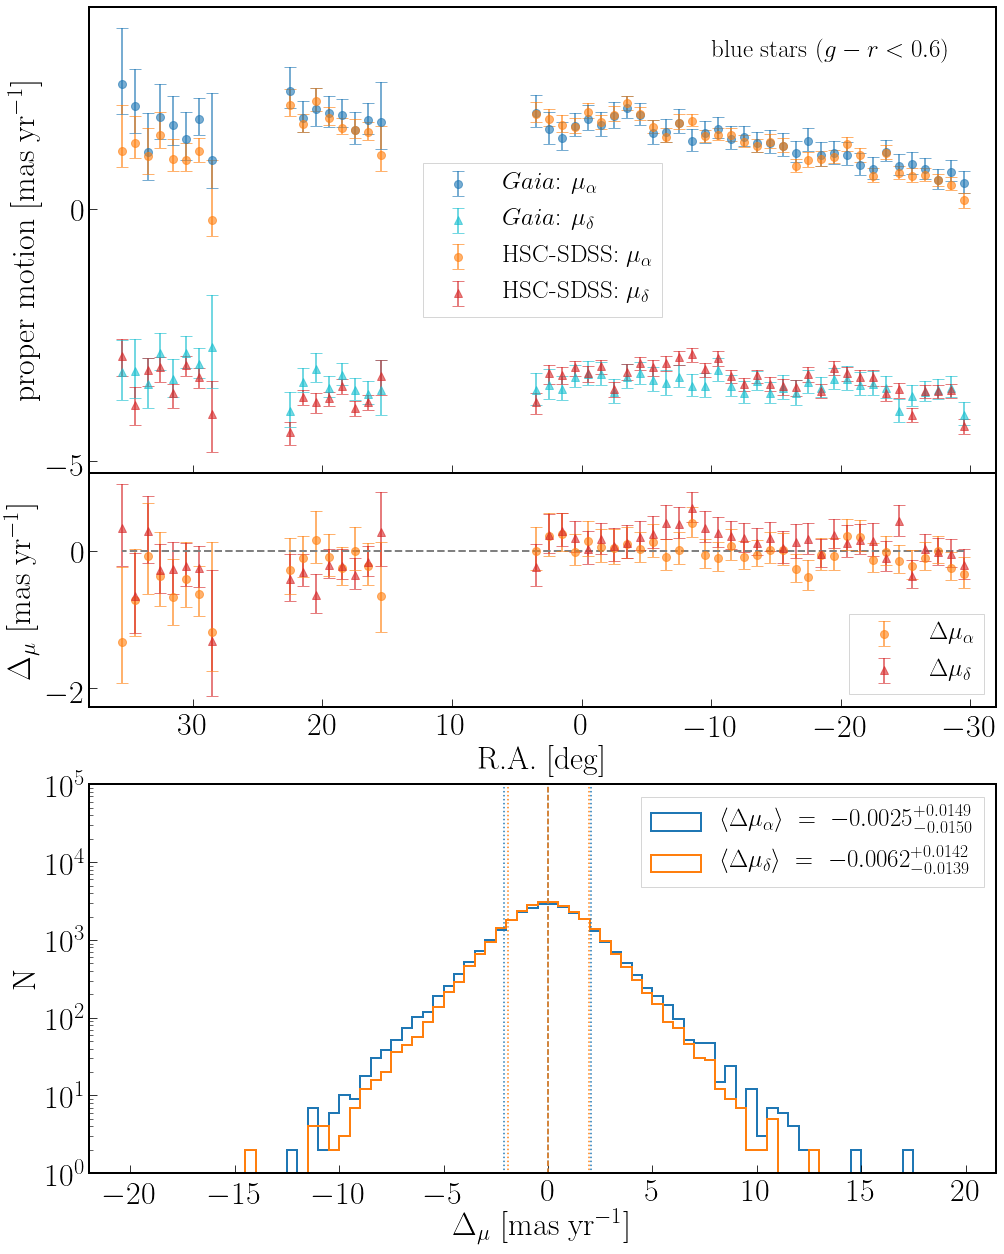

In [301]:
plt.figure(figsize=(14,18))
ax=plt.axes([0.05,0.59,0.9,0.36])
#plt.title(r'$\mu_\alpha$ and $\mu_\delta$ versus R.A. by stars matched with Gaia')
#plt.hlines(np.mean(mss.dra_cl),np.min(xm),np.max(xm),color='darkblue')
#plt.hlines(np.mean(mss.ddec_cl),np.min(xm),np.max(xm),color='darkred')
#plt.plot(xm,np.array(ram),color='darkblue')
#plt.plot(xm,np.array(decm),color='darkred')
plt.errorbar(x1Bin1,m1edianBin1,s1igGbin1,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:blue',label=r'$Gaia$: $\mu_\alpha$')
plt.errorbar(x1Bin11,m1edianBin11,s1igGbin11,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:cyan',label=r'$Gaia$: $\mu_\delta$')
#plt.plot(xm,ram3,color='cyan')
#plt.plot(xm,decm3,color='pink')
plt.errorbar(x1Bin2,m1edianBin2,s1igGbin2,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:orange',label=r'HSC-SDSS: $\mu_\alpha$')
plt.errorbar(x1Bin21,m1edianBin21,s1igGbin21,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:red',label=r'HSC-SDSS: $\mu_\delta$')
plt.legend(loc=10)
plt.xlim(38,-32)
plt.text(-10,3,'blue stars ($g-r<0.6$)')
ax.yaxis.set_major_locator(MultipleLocator(5))
plt.ylabel('proper motion [$\mathrm{mas\ yr^{-1}}$]',fontsize=32)
ax=plt.axes([0.05,0.41,0.9,0.18])
plt.errorbar(x1Bin3,m1edianBin3,s1igGbin3,fmt='o',capsize=6,markersize=8,alpha=0.6,color='tab:orange',label=r'$\Delta\mu_\alpha$')
plt.errorbar(x1Bin31,m1edianBin31,s1igGbin31,fmt='^',capsize=6,markersize=8,alpha=0.6,color='tab:red',label=r'$\Delta\mu_\delta$')
plt.hlines(0,min(x1Bin1),max(x1Bin1),color='grey',linestyle='dashed')
plt.legend()
plt.xlim(38,-32)
plt.xlabel('R.A. [deg]')
plt.ylabel('$\Delta_\mu$ [$\mathrm{mas\ yr^{-1}}$]',fontsize=32)


ax=plt.axes([0.05,0.05,0.9,0.3])
plt.hist(pmra3,bins=np.arange(-20,20,0.5),linewidth=2,histtype='step',color='tab:blue',label=r'$\langle \Delta\mu_{\alpha}\rangle \ = \ %0.4f^{+%0.4f}_{-%0.4f}$'\
         %(np.median(pmra3),sig1(pmra3.values),sig2(pmra3.values)))#,np.std(g.pmra_2-g.pmra_cl)))
plt.vlines(np.median(pmra3),0,1e5,linewidth=1.5,linestyles='dashed',color='tab:blue')
plt.hist(pmdec3,bins=np.arange(-20,20,0.5),linewidth=2,histtype='step',color='tab:orange',label=r'$\langle \Delta\mu_{\delta}\rangle\ =\ %0.4f^{+%0.4f}_{-%0.4f}$'\
         %(np.median(pmdec3),sig1(pmdec3.values),sig2(pmdec3.values)))#,np.std(g.pmdec_2-g.pmdec_cl)))
plt.vlines(np.median(pmdec3),0,1e5,linewidth=1.5,linestyles='dashed',color='tab:orange')
plt.vlines(np.percentile(pmra3,16),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:blue')
plt.vlines(np.percentile(pmra3,84),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:blue')
plt.vlines(np.percentile(pmdec3,16),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:orange')
plt.vlines(np.percentile(pmdec3,84),0,1e5,linewidth=1.5,linestyles='dotted',color='tab:orange')
plt.yscale('log')
plt.ylim([1,1e5])
plt.ylabel('N',fontsize=32)
plt.xlabel(r'$\Delta_\mu\ [\mathrm{mas\ yr^{-1}}]$',fontsize=32)
plt.legend()
plt.savefig('/Users/tianqiu/Documents/final/newgaia/gaia_blue_dcr.pdf')

## for all matched stars

In [238]:
ms=pd.read_csv('../Downloads/catalog/final/4/starall.csv')

In [249]:
ms=ms[ms.gi<4]

In [250]:
ms.to_csv('../Downloads/catalog/final/4/starall.csv')

In [303]:
x1Bin1, n1Pts1, m1edianBin1, s1igGbin1 = fitMedians(g.gi, g.pmra_cl-g.pmra_2, 0.175, 4.025, 77, 0)
x1Bin2, n1Pts2, m1edianBin2, s1igGbin2 = fitMedians(g.gi, g.pmdec_cl-g.pmdec_2, 0.175, 4.025, 77, 0)

In [306]:
tt=[]
for i in range(len(x1Bin1)-1):
    t=ms[(ms.gi>x1Bin1[i])&(ms.gi<x1Bin1[i+1])]
    t['pmra_cl3']=t.pmra_cl-inter(t.gi-x1Bin1[i],m1edianBin1[i],m1edianBin1[i+1])
    t['pmdec_cl3']=t.pmdec_cl-inter(t.gi-x1Bin2[i],m1edianBin2[i],m1edianBin2[i+1])
    tt.append(t)
    print(i)
tt=pd.concat(tt)

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75


In [313]:
tt.to_csv('../Downloads/catalog/final/4/starall.csv',index=False)

## for quasar validation

In [5]:
q=pd.read_csv('../Downloads/catalog/final/matchedquasar.csv')

In [6]:
len(q)

8934

In [14]:
tt=[]
for i in range(len(x1Bin1)-1):
    t=q[(q.g_psfflux_mag-q.i_psfflux_mag>x1Bin1[i])&(q.g_psfflux_mag-q.i_psfflux_mag<x1Bin1[i+1])]
    t['pmra_cl3']=t.pmra-inter(t.g_psfflux_mag-t.i_psfflux_mag-x1Bin1[i],m1edianBin1[i],m1edianBin1[i+1])
    t['pmdec_cl3']=t.pmdec-inter(t.g_psfflux_mag-t.i_psfflux_mag-x1Bin2[i],m1edianBin2[i],m1edianBin2[i+1])
    tt.append(t)

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [15]:
tt=pd.concat(tt)

In [16]:
len(tt)

6366

In [17]:
q=tt

In [21]:

Znum=pd.read_csv('../Downloads/catalog/final/calibration/table/Znum.csv')
Zra=pd.read_csv('../Downloads/catalog/final/calibration/table/Zra.csv')
Zdec=pd.read_csv('../Downloads/catalog/final/calibration/table/Zdec.csv')
Zrasem=pd.read_csv('../Downloads/catalog/final/calibration/table/Zrasem.csv')
Zdecsem=pd.read_csv('../Downloads/catalog/final/calibration/table/Zdecsem.csv')
Zraerr=pd.read_csv('../Downloads/catalog/final/calibration/table/Zraerr.csv')
Zdecerr=pd.read_csv('../Downloads/catalog/final/calibration/table/Zdecerr.csv')

In [22]:
mg=pd.read_csv('../Downloads/catalog/final/totalgalaxy.csv')

In [23]:
x=np.arange(-30,36.05,0.05)#1320
y=np.arange(-1.25,1.3,0.05)#50
def cali_qso(i):#for i in range(len(x)-1): #columns, ra
    print(i)
    t=[]
    for j in range(len(y)-1): #rows, dec
        tt=q[(q.i_sdsscentroid_ra<x[i+1])&(q.i_sdsscentroid_ra>x[i])&(q.i_sdsscentroid_dec>y[j])&(q.i_sdsscentroid_dec<y[j+1])].copy()
        if len(tt)==0:
            continue
        tt['pmra_cl']=tt.pmra_cl3-Zra.iloc[j,i]
        tt['pmdec_cl']=tt.pmdec_cl3-Zdec.iloc[j,i]
        t.append(tt)
    if len(t)!=0:
        ttt=pd.concat(t)
        print(i,'-')
        return ttt
    else:
        print(i,'-0')
        return tt

In [24]:
pool1=mp.Pool(12)
data=pool1.map(cali_qso,range(len(x)-1))
pool1.close()

28
0
112
56
168
196
84
140
252
224
280
308
0 -
280 -
28 -
252 -
56 -
140 -
84 -
196 -
57
85
1
253
281
141
29
197
168 -
224 -
112 -
308 -
169
225
309
113
1 -
2
29 -
57 -
30
58
141 -
142
197 -
198
281 -
282
253 -
254
85 -
86
225 -
226
169 -
309 -
170
310
113 -
114
2 -
3
30 -
31
58 -
59
142 -
143
226 -
227
198 -
86 -
199
87
282 -
310 -
311
283
170 -
171
254 -
255
114 -
115
3 -
4
31 -
32
143 -
199 -
87 -
59 -
60
144
88
200
227 -
283 -
311 -
228
284
312
171 -
172
255 -
256
115 -
116
4 -
5
200 -
32 -
201
33
144 -
145
88 -
89
228 -
284 -
229
285
60 -
256 -
312 -
172 -
257
313
61
173
116 -
117
5 -
6
145 -
146
285 -
201 -
286
202
33 -
34
89 -
90
229 -
230
61 -
62
173 -
257 -
313 -
117 -
118
174
314
258
6 -
7
286 -
287
146 -
34 -
202 -
230 -
35
147
90 -
231
203
91
62 -
63
174 -
175
258 -
259
314 -
315
118 -
119
7 -
8
287 -0
288
35 -
36
231 -
147 -
203 -
63 -
91 -
259 -
148
204
232
64
92
315 -
175 -
260
316
176
119 -
120
8 -
9
288 -
289
36 -
37
148 -
92 -
93
149
232 -
233
204 -
205
260 -
64 -
176

715 -0
716
907 -0
908
743 -0
744
987 -
771 -0
687 -0
688
772
988
855 -0
856
881 -0
882
799 -0
800
827 -0
828
716 -0
960 -
744 -0
908 -0
932 -
717
909
961
745
933
772 -0
773
688 -0
689
856 -0
800 -0
988 -
882 -0
828 -0
857
801
883
989
829
745 -0
961 -
717 -0
909 -0
746
962
910
718
773 -0
774
933 -
689 -0
934
690
857 -0
858
883 -0
884
801 -0
829 -0
802
830
910 -0
746 -0
989 -
718 -0
747
911
990
719
774 -0
962 -
775
963
690 -0
691
934 -
935
858 -0
884 -0
830 -0
802 -0
803
859
885
831
747 -0
748
719 -0
911 -
912
720
775 -0
990 -
963 -
691 -0
991
776
692
964
859 -0
860
831 -0
885 -0
886
832
935 -
803 -0
936
804
748 -0
720 -0
721
749
912 -
913
776 -0
777
692 -0
693
991 -
992
964 -
804 -0
860 -0
886 -0
832 -0
805
861
887
965
833
936 -
937
721 -0
722
749 -0
750
913 -
777 -0
693 -0
694
914
778
992 -
993
887 -0
861 -0
888
862
833 -0
805 -0
806
834
965 -
966
722 -0
750 -0
723
751
937 -
938
778 -0
779
914 -
915
694 -0
695
888 -0
862 -0
834 -0
806 -0
863
889
807
835
993 -
994
751 -0
752
723 -0
966 

In [25]:
qc=pd.concat(data)

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [26]:
len(q)

6366

In [27]:
#clip
def calc_cov(mc):
    if mc.shape[0]==2 and mc.shape[1]!=2:
        mc=mc.T
    cov=np.cov(mc.T)
    return cov
def clip_q(t):
    l=[]
    mx2=np.array([t.pmra_cl,t.pmdec_cl])
    mx2=mx2.T
    for k,y in enumerate(mx2):
        cov=calc_cov(mx2)
        if (y-mx2.mean(0)).dot(np.linalg.inv(cov)).dot(y-mx2.mean(0))<11.8:
            l.append(k)
    return t.iloc[l]

In [28]:
qc=clip_q(qc)

In [29]:
len(qc)

6288

In [30]:
qc.to_csv('../Downloads/catalog/final/matchedquasar2.csv')

In [63]:
xm=[]
ram=[]
decm=[]
ram2=[]
decm2=[]
ram3=[]
decm3=[]
rae=[]
dece=[]
rae2=[]
dece2=[]
rae3=[]
dece3=[]
        
for j in range(-30,37):
    t1=mg[(mg.i_sdsscentroid_ra>j)&(mg.i_sdsscentroid_ra<=(1+j))]
    t2=qc[(qc.i_sdsscentroid_ra>j)&(qc.i_sdsscentroid_ra<=(j+1))]
    if t2.empty:
        continue
    xm.append(j)
    
    ram.append(np.mean(t1.pmra))
    decm.append(np.mean(t1.pmdec))
    ram2.append(np.mean(t2.pmra_cl3))
    decm2.append(np.mean(t2.pmdec_cl3))
    ram3.append(np.mean(t2.pmra_cl))
    decm3.append(np.mean(t2.pmdec_cl))
    rae.append(stats.sem(t1.pmra))
    dece.append(stats.sem(t1.pmdec))
    rae2.append(stats.sem(t2.pmra_cl3))
    dece2.append(stats.sem(t2.pmdec_cl3))
    rae3.append(np.sqrt(stats.sem(t1.pmra)**2+stats.sem(t2.pmra_cl3)**2))
    dece3.append(np.sqrt(stats.sem(t1.pmdec)**2+stats.sem(t2.pmdec_cl3)**2))

In [66]:
np.mean(mg.pmdec)

0.26783623462318984

In [68]:
np.mean(qc.pmdec_cl3)

0.35287011941811686

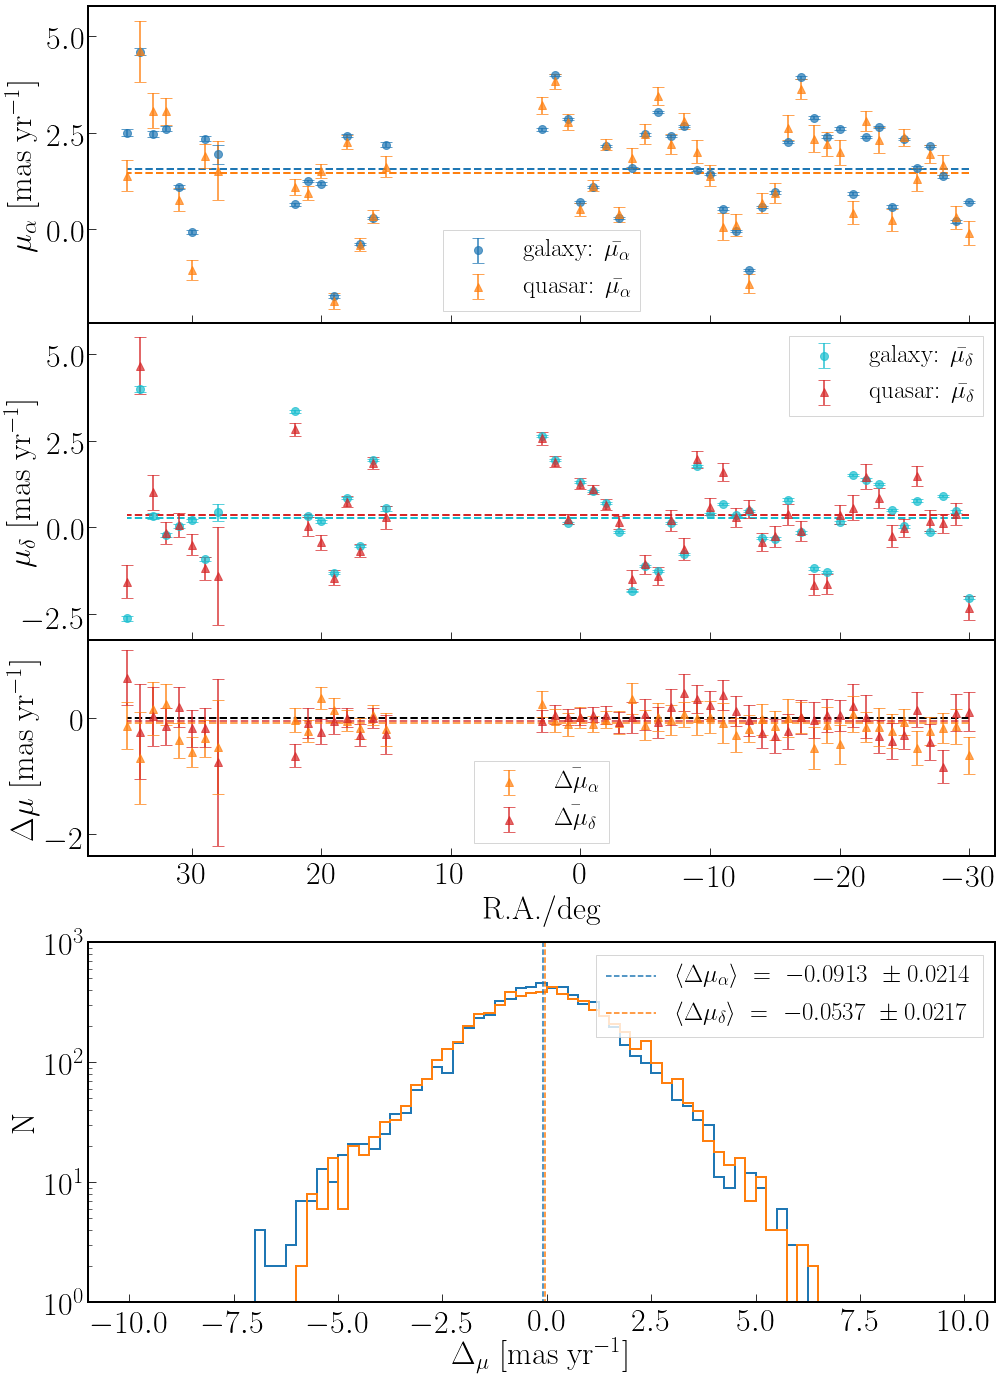

In [64]:
ax=plt.figure(figsize=(14,20))
ax.add_axes([0.05,0.73,0.9,0.22])
#plt.title(r'$Angular offset per year versus R.A. by quasars and galaxies',fontsize=25)
plt.hlines(np.mean(mg.pmra),np.min(xm),np.max(xm),linestyles='dashed',color='tab:blue')
plt.hlines(np.mean(qc.pmra_cl3),np.min(xm),np.max(xm),linestyles='dashed',color='tab:orange')
plt.errorbar(xm,ram,yerr=rae,fmt='o',capsize=6,markersize=8,alpha=0.7,color='tab:blue',label=r'galaxy: $\bar{\mu_{\alpha}}$')
plt.errorbar(xm,ram2,yerr=rae2,fmt='^',capsize=6,markersize=8,alpha=0.7,color='tab:orange',label=r'quasar: $\bar{\mu_{\alpha}}$')
plt.legend()
plt.xlim(38,-32)
plt.ylabel(r'$\mu_{\alpha}\ [\mathrm{mas\ yr^{-1}}$]',fontsize=32)
ax.add_axes([0.05,0.51,0.9,0.22])
plt.hlines(np.mean(mg.pmdec),np.min(xm),np.max(xm),linestyles='dashed',color='tab:cyan')
plt.hlines(np.mean(qc.pmdec_cl3),np.min(xm),np.max(xm),linestyles='dashed',color='tab:red')
plt.errorbar(xm,decm,yerr=dece,fmt='o',capsize=6,markersize=8,alpha=0.7,color='tab:cyan',label=r'galaxy: $\bar{\mu_{\delta}}$')
plt.errorbar(xm,decm2,yerr=dece2,fmt='^',capsize=6,markersize=8,alpha=0.7,color='tab:red',label=r'quasar: $\bar{\mu_{\delta}}$')
plt.legend()
plt.xlim(38,-32)
plt.ylabel(r'$\mu_{\delta}\ [\mathrm{mas\ yr^{-1}}$]',fontsize=32,labelpad=-20)
ax.add_axes([0.05,0.36,0.9,0.15])
plt.hlines(0,np.min(xm),np.max(xm),linestyles='dashed',color='black')
plt.errorbar(xm,ram3,rae3,fmt='^',capsize=6,markersize=8,alpha=0.7,color='tab:orange',label=r'$\bar{\Delta\mu_{\alpha}}$')
plt.errorbar(xm,decm3,dece3,fmt='^',capsize=6,markersize=8,alpha=0.7,color='tab:red',label=r'$\bar{\Delta\mu_{\delta}}$')
plt.hlines(np.mean(qc.pmra_cl),np.min(xm),np.max(xm),alpha=0.7,linestyles='dashed',color='tab:orange')
plt.hlines(np.mean(qc.pmdec_cl),np.min(xm),np.max(xm),alpha=0.7,linestyles='dashed',color='tab:red')
plt.legend()
plt.xlim(38,-32)
plt.xlabel('R.A./deg',fontsize=32)
plt.ylabel(r'$\Delta\mu\ [\mathrm{mas\ yr^{-1}}$]',fontsize=32)

ax.add_axes([0.05,0.05,0.9,0.25])
bins=np.arange(-10,10,0.25)
plt.hist(qc.pmra_cl,bins=bins,linewidth=2,histtype='step',color='tab:blue')
plt.hist(qc.pmdec_cl,bins=bins,linewidth=2,histtype='step',color='tab:orange')
plt.yscale('log')
plt.vlines(np.mean(qc.pmra_cl),0,1e3,linewidth=1.5,linestyles='dashed',color='tab:blue',label=r'$\langle \Delta\mu_{\alpha}\rangle \ =\  %0.4f\ \pm %0.4f$'%(np.mean(qc.pmra_cl),stats.sem(qc.pmra_cl)))
plt.vlines(np.mean(qc.pmdec_cl),0,1e3,linewidth=1.5,linestyles='dashed',color='tab:orange',label=r'$\langle \Delta\mu_{\delta}\rangle \ =\ %0.4f\ \pm %0.4f$'%(np.mean(qc.pmdec_cl),stats.sem(qc.pmdec_cl)))
#plt.vlines(np.percentile(qc.pmra_cl,16),0,1e3,linewidth=1.5,linestyles='dotted',color='tab:blue')
#plt.vlines(np.percentile(qc.pmdec_cl,16),0,1e3,linewidth=1.5,linestyles='dotted',color='tab:orange')
#plt.vlines(np.percentile(qc.pmra_cl,84),0,1e3,linewidth=1.5,linestyles='dotted',color='tab:blue')
#plt.vlines(np.percentile(qc.pmdec_cl,84),0,1e3,linewidth=1.5,linestyles='dotted',color='tab:orange')
plt.ylim([1,1e3])
plt.legend()
plt.title('')
plt.ylabel('N',fontsize=32)
plt.xlabel(r'$\Delta_\mu\ [\mathrm{mas\ yr^{-1}}$]',fontsize=32)
plt.savefig('/Users/tianqiu/Documents/final/qso_after_DCR.pdf')

### only galaxies used for quasar validation

In [69]:
x=np.arange(-30,36.05,0.05)#1320
y=np.arange(-1.25,1.3,0.05)#50
def cali_qso(i):#for i in range(len(x)-1): #columns, ra
    print(i)
    t=[]
    for j in range(len(y)-1): #rows, dec
        tt=q[(q.i_sdsscentroid_ra<x[i+1])&(q.i_sdsscentroid_ra>x[i])&(q.i_sdsscentroid_dec>y[j])&(q.i_sdsscentroid_dec<y[j+1])].copy()
        if len(tt)==0:
            continue
        tt['pmra_cl']=tt.pmra_cl3-Zra.iloc[j,i]
        tt['pmdec_cl']=tt.pmdec_cl3-Zdec.iloc[j,i]
        tt['pmra_g']=Zra.iloc[j,i]
        tt['pmdec_g']=Zdec.iloc[j,i]
        t.append(tt)
    if len(t)!=0:
        ttt=pd.concat(t)
        print(i,'-')
        return ttt
    else:
        print(i,'-0')
        return tt

In [70]:
pool1=mp.Pool(12)
data=pool1.map(cali_qso,range(len(x)-1))
pool1.close()

0
28
84
56
224
252
112
140
280
168
308
196
252 -
196 -
28 -
280 -
0 -
84 -
56 -
281
140 -
253
197
308 -
1
29
85
141
309
57
224 -
225
168 -
169
112 -
113
1 -
2
197 -
198
141 -
29 -
142
30
57 -
58
309 -
310
281 -
225 -
226
253 -
282
254
85 -
86
169 -
170
113 -
114
2 -
3
30 -
31
58 -
59
198 -
199
310 -
311
86 -
87
226 -
282 -
227
142 -
283
143
170 -
171
254 -
255
114 -
115
3 -
4
311 -
312
31 -
143 -
32
144
199 -
200
227 -
228
171 -
172
283 -
59 -
87 -
284
88
60
255 -
256
115 -
116
284 -
32 -
4 -
144 -
200 -
312 -
5
145
228 -
285
201
33
313
229
60 -
61
172 -
173
256 -
257
88 -
89
116 -
117
5 -
6
285 -
286
201 -
313 -
145 -
229 -
202
61 -
230
173 -
146
33 -
314
34
174
62
257 -
258
89 -
90
117 -
118
6 -
7
286 -
287
230 -
231
146 -
314 -
258 -
34 -
202 -
174 -
35
147
315
62 -
259
175
203
63
90 -
91
118 -
119
287 -0
7 -
8
288
231 -
232
175 -
176
147 -
35 -
315 -
148
36
316
259 -
260
203 -
204
63 -
64
91 -
92
119 -
120
288 -
289
8 -
232 -
148 -
233
9
149
260 -
176 -
261
177
36 -
316 -
317
37
20

799 -0
827 -0
800
828
906 -0
907
855 -0
716 -0
856
717
687 -0
688
881 -0
882
772 -0
959 -
773
960
744 -0
745
828 -0
987 -
800 -0
829
801
988
907 -0
931 -
717 -0
856 -0
688 -0
932
908
718
857
689
882 -0
883
773 -0
774
745 -0
960 -
746
961
801 -0
829 -0
802
830
857 -0
908 -0
858
909
718 -0
719
689 -0
690
988 -
883 -0
989
774 -0
884
932 -
775
933
746 -0
747
909 -0
830 -0
961 -
858 -0
802 -0
690 -0
719 -0
831
962
803
859
910
720
691
884 -0
885
775 -0
776
747 -0
748
933 -
989 -
934
990
831 -0
803 -0
832
804
910 -0
911
962 -
963
691 -0
692
859 -0
860
720 -0
721
885 -0
886
776 -0
777
748 -0
749
721 -0
832 -0
804 -0
934 -
860 -0
990 -
861
911 -
692 -0
805
935
991
833
722
693
912
963 -
964
886 -0
887
777 -0
778
749 -0
750
805 -0
806
833 -0
834
693 -0
722 -0
694
723
861 -0
991 -
862
992
935 -
912 -
778 -0
887 -0
913
888
936
779
964 -
965
750 -0
751
834 -0
806 -0
723 -0
694 -0
862 -0
835
807
724
695
863
992 -
993
888 -0
889
913 -
914
779 -0
780
936 -
751 -0
752
937
965 -
966
695 -0
696
807 -0
835

In [71]:
qc=pd.concat(data)

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [72]:
#clip
def calc_cov(mc):
    if mc.shape[0]==2 and mc.shape[1]!=2:
        mc=mc.T
    cov=np.cov(mc.T)
    return cov
def clip_q(t):
    l=[]
    mx2=np.array([t.pmra_cl,t.pmdec_cl])
    mx2=mx2.T
    for k,y in enumerate(mx2):
        cov=calc_cov(mx2)
        if (y-mx2.mean(0)).dot(np.linalg.inv(cov)).dot(y-mx2.mean(0))<11.8:
            l.append(k)
    return t.iloc[l]

In [73]:
qc=clip_q(qc)

In [74]:
len(qc)

6288

In [75]:
xm=[]
ram=[]
decm=[]
ram2=[]
decm2=[]
ram3=[]
decm3=[]
rae=[]
dece=[]
rae2=[]
dece2=[]
rae3=[]
dece3=[]
        
for j in range(-30,37):
    t2=qc[(qc.i_sdsscentroid_ra>j)&(qc.i_sdsscentroid_ra<=(j+1))]
    if t2.empty:
        continue
    xm.append(j)
    
    ram.append(np.mean(t2.pmra_g))
    decm.append(np.mean(t2.pmdec_g))
    ram2.append(np.mean(t2.pmra_cl3))
    decm2.append(np.mean(t2.pmdec_cl3))
    ram3.append(np.mean(t2.pmra_cl))
    decm3.append(np.mean(t2.pmdec_cl))
    rae.append(stats.sem(t2.pmra_g))
    dece.append(stats.sem(t2.pmdec_g))
    rae2.append(stats.sem(t2.pmra_cl3))
    dece2.append(stats.sem(t2.pmdec_cl3))
    rae3.append(np.sqrt(stats.sem(t2.pmra_g)**2+stats.sem(t2.pmra_cl3)**2))
    dece3.append(np.sqrt(stats.sem(t2.pmdec_g)**2+stats.sem(t2.pmdec_cl3)**2))

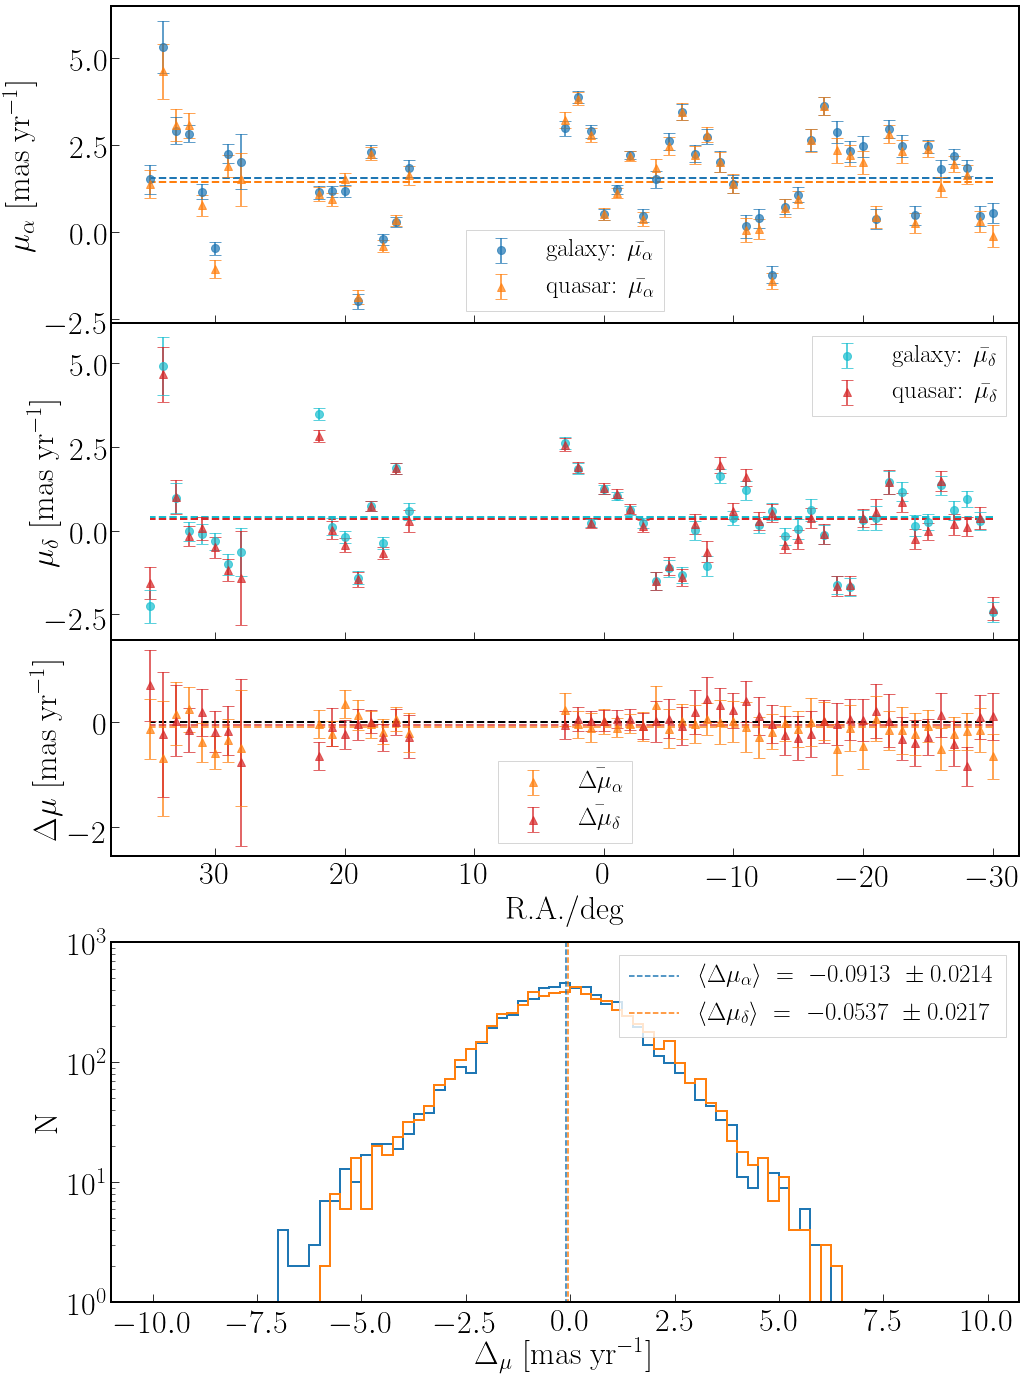

In [79]:
ax=plt.figure(figsize=(14,20))
ax.add_axes([0.05,0.73,0.9,0.22])
#plt.title(r'$Angular offset per year versus R.A. by quasars and galaxies',fontsize=25)
plt.hlines(np.mean(qc.pmra_g),np.min(xm),np.max(xm),linestyles='dashed',color='tab:blue')
plt.hlines(np.mean(qc.pmra_cl3),np.min(xm),np.max(xm),linestyles='dashed',color='tab:orange')
plt.errorbar(xm,ram,yerr=rae,fmt='o',capsize=6,markersize=8,alpha=0.7,color='tab:blue',label=r'galaxy: $\bar{\mu_{\alpha}}$')
plt.errorbar(xm,ram2,yerr=rae2,fmt='^',capsize=6,markersize=8,alpha=0.7,color='tab:orange',label=r'quasar: $\bar{\mu_{\alpha}}$')
plt.legend()
plt.xlim(38,-32)
plt.ylabel(r'$\mu_{\alpha}\ [\mathrm{mas\ yr^{-1}}$]',fontsize=32)
ax.add_axes([0.05,0.51,0.9,0.22])
plt.hlines(np.mean(qc.pmdec_g),np.min(xm),np.max(xm),linestyles='dashed',color='tab:cyan')
plt.hlines(np.mean(qc.pmdec_cl3),np.min(xm),np.max(xm),linestyles='dashed',color='tab:red')
plt.errorbar(xm,decm,yerr=dece,fmt='o',capsize=6,markersize=8,alpha=0.7,color='tab:cyan',label=r'galaxy: $\bar{\mu_{\delta}}$')
plt.errorbar(xm,decm2,yerr=dece2,fmt='^',capsize=6,markersize=8,alpha=0.7,color='tab:red',label=r'quasar: $\bar{\mu_{\delta}}$')
plt.legend()
plt.xlim(38,-32)
plt.ylabel(r'$\mu_{\delta}\ [\mathrm{mas\ yr^{-1}}$]',fontsize=32,labelpad=-20)
ax.add_axes([0.05,0.36,0.9,0.15])
plt.hlines(0,np.min(xm),np.max(xm),linestyles='dashed',color='black')
plt.errorbar(xm,ram3,rae3,fmt='^',capsize=6,markersize=8,alpha=0.7,color='tab:orange',label=r'$\bar{\Delta\mu_{\alpha}}$')
plt.errorbar(xm,decm3,dece3,fmt='^',capsize=6,markersize=8,alpha=0.7,color='tab:red',label=r'$\bar{\Delta\mu_{\delta}}$')
plt.hlines(np.mean(qc.pmra_cl),np.min(xm),np.max(xm),alpha=0.7,linestyles='dashed',color='tab:orange')
plt.hlines(np.mean(qc.pmdec_cl),np.min(xm),np.max(xm),alpha=0.7,linestyles='dashed',color='tab:red')
plt.legend()
plt.xlim(38,-32)
plt.xlabel('R.A./deg',fontsize=32)
plt.ylabel(r'$\Delta\mu\ [\mathrm{mas\ yr^{-1}}$]',fontsize=32)

ax.add_axes([0.05,0.05,0.9,0.25])
bins=np.arange(-10,10,0.25)
plt.hist(qc.pmra_cl,bins=bins,linewidth=2,histtype='step',color='tab:blue')
plt.hist(qc.pmdec_cl,bins=bins,linewidth=2,histtype='step',color='tab:orange')
plt.yscale('log')
plt.vlines(np.mean(qc.pmra_cl),0,1e3,linewidth=1.5,linestyles='dashed',color='tab:blue',label=r'$\langle \Delta\mu_{\alpha}\rangle \ =\  %0.4f\ \pm %0.4f$'%(np.mean(qc.pmra_cl),stats.sem(qc.pmra_cl)))
plt.vlines(np.mean(qc.pmdec_cl),0,1e3,linewidth=1.5,linestyles='dashed',color='tab:orange',label=r'$\langle \Delta\mu_{\delta}\rangle \ =\ %0.4f\ \pm %0.4f$'%(np.mean(qc.pmdec_cl),stats.sem(qc.pmdec_cl)))
#plt.vlines(np.percentile(qc.pmra_cl,16),0,1e3,linewidth=1.5,linestyles='dotted',color='tab:blue')
#plt.vlines(np.percentile(qc.pmdec_cl,16),0,1e3,linewidth=1.5,linestyles='dotted',color='tab:orange')
#plt.vlines(np.percentile(qc.pmra_cl,84),0,1e3,linewidth=1.5,linestyles='dotted',color='tab:blue')
#plt.vlines(np.percentile(qc.pmdec_cl,84),0,1e3,linewidth=1.5,linestyles='dotted',color='tab:orange')
plt.ylim([1,1e3])
plt.legend()
plt.title('')
plt.ylabel('N',fontsize=32)
plt.xlabel(r'$\Delta_\mu\ [\mathrm{mas\ yr^{-1}}$]',fontsize=32)
plt.savefig('/Users/tianqiu/Documents/final/qso_after_DCR.pdf')

# old

In [5]:
g=pd.read_csv('../Downloads/catalog/gaia_dist-result.csv')


In [12]:
g[pd.notna(g.radial_velocity)]

,source_id,ra,dec,pmra,pmdec,radial_velocity,phot_g_mean_mag,parallax,r_est,r_lo,r_hi,r_len,result_flag,modality_flag
4436012,4266507914985774848,283.160773,0.642909,-2.846219,-5.174090,219.246886,18.216473,-0.059517,3591.513631,2264.574608,5752.652088,1171.187301,1,1
4941904,4278607838591500800,282.559066,1.194339,-1.882511,-4.490872,40.944767,17.597990,0.050315,3831.567615,2589.522135,5835.127878,1132.772648,1,1


/Users/tianqiu/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3507: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  self.set_ylim(upper, lower, auto=None)


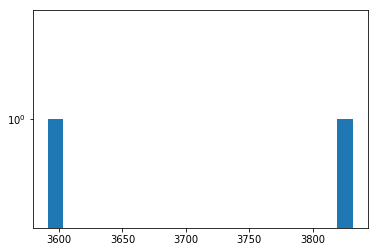

In [11]:
plt.hist(g[pd.notna(g.radial_velocity)].r_est,bins=20)
plt.yscale('log')

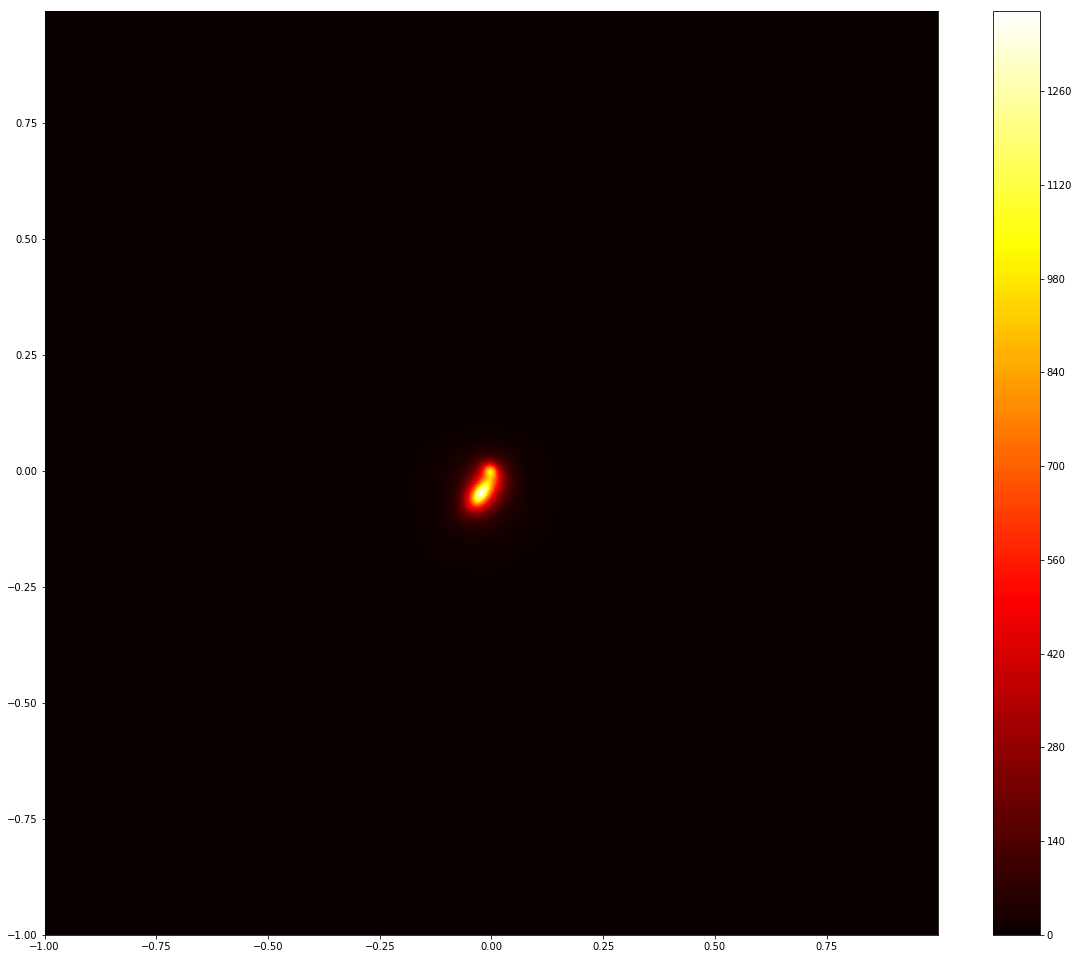

In [21]:
plt.figure(figsize=(20,17))
i=0
x=g.pmra/100
y=g.pmdec/100
hist=np.histogram2d(x,y,bins=3000)
z=np.transpose(hist[0])
plt.contourf(hist[1][0:-1],hist[2][0:-1],z,levels=300,cmap='hot')
plt.colorbar()

Text(0, 0.5, '$\\delta_{dec}/arcsec$')

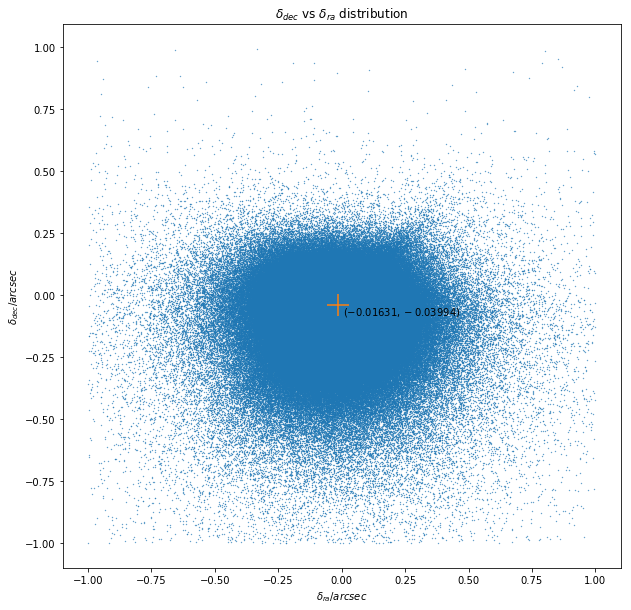

In [12]:
plt.figure(figsize=(10,10))
plt.title(r'$\delta_{dec}$ vs $\delta_{ra}$ distribution')
plt.scatter(g.pmra/100,g.pmdec/100,alpha=1,s=0.1)
plt.scatter(np.median(g.pmra)/100,np.median(g.pmdec)/100,s=500,marker='+')
plt.text(np.median(g.pmra)/100+0.02,np.median(g.pmdec)/100-0.04,'$(%0.5f,%0.5f)$'%(np.median(g.pmra)/100,np.median(g.pmdec)/100))
plt.xlabel(r'$\delta_{ra}/arcsec$')
plt.ylabel(r'$\delta_{dec}/arcsec$')

In [104]:
xm=[]
ram=[]
decm=[]
rae=[]
dece=[]
for i in range(360):
    t=g[(g.ra>i)&(g.ra<=(i+1))]
    if t.empty:
        continue
    xm.append(i)
    #mdelta_ra=(t.HSCra.values-t.S82ra1.values)*3600
    #mdelta_dec=(t.HSCdec.values-t.S82dec1.values)*3600
    #ram.append(np.mean(mdelta_ra))
    #decm.append(np.mean(mdelta_dec))
    ram.append(np.mean(t.pmra)/100)
    decm.append(np.mean(t.pmdec)/100)
    rae.append(stats.sem(t.pmra)/100)
    dece.append(stats.sem(t.pmdec)/100)
    

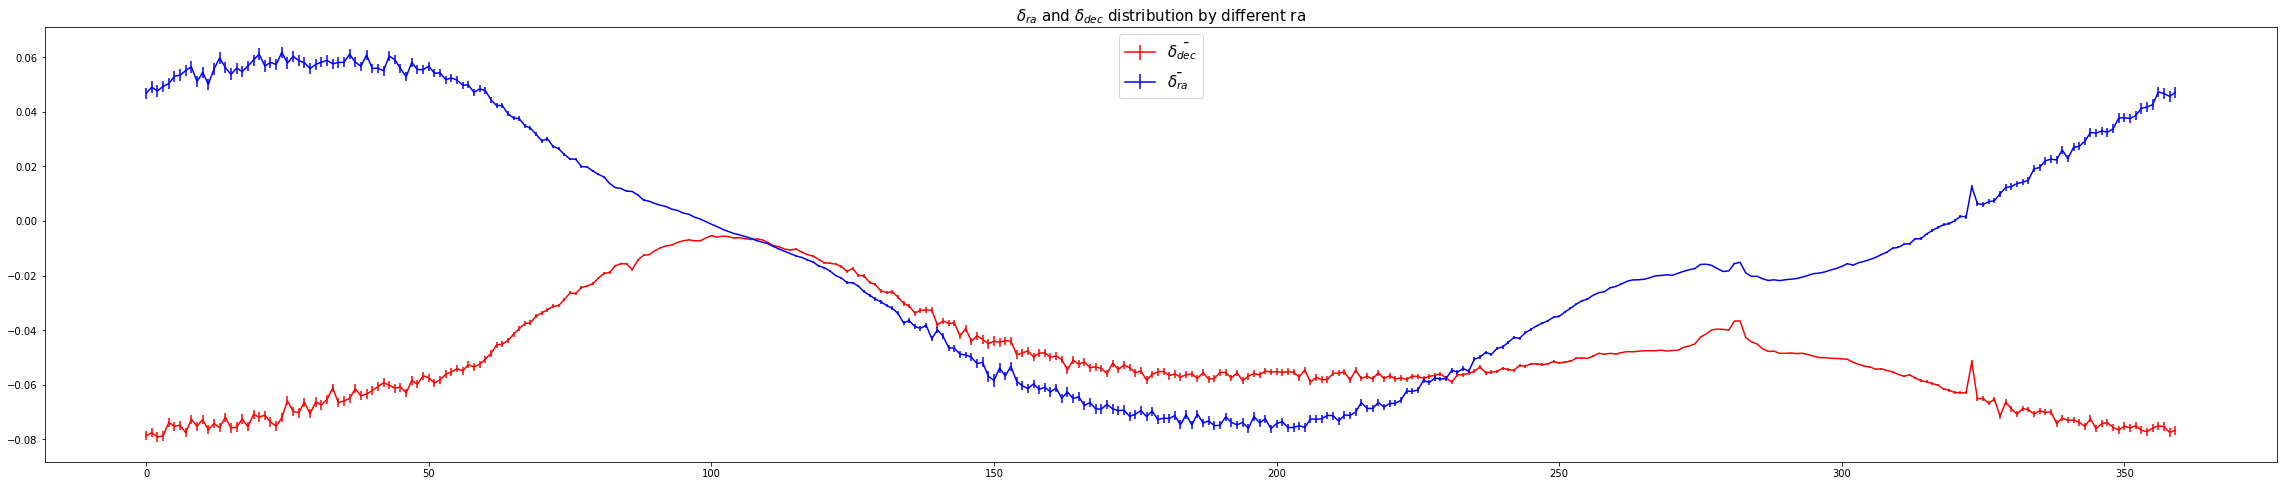

In [106]:
plt.figure(figsize=(40,8))
plt.errorbar(xm,decm,dece,color='red', label=r'$\bar{\delta_{dec}}$')
plt.errorbar(xm,ram,rae,color='blue', label=r'$\bar{\delta_{ra}}$')
plt.legend(loc=9,fontsize=15)
plt.title(r'$\delta_{ra}$ and $\delta_{dec}$ distribution by different ra',fontsize=15)
plt.savefig('gaia_pm_gaia_errorbar.png')

In [135]:
dl=[]
db=[]
for i in range(0,360):
    c1 = SkyCoord(ra=i*u.degree, dec=0*u.degree, frame='icrs')
    dra=ram[i]/3600
    ddec=decm[i]/3600
    c2 = SkyCoord(ra=(i+dra)*u.degree, dec=ddec*u.degree, frame='icrs')
    dl.append((c2.galactic.l.deg-c1.galactic.l.deg))
    db.append((c2.galactic.b.deg-c1.galactic.b.deg))

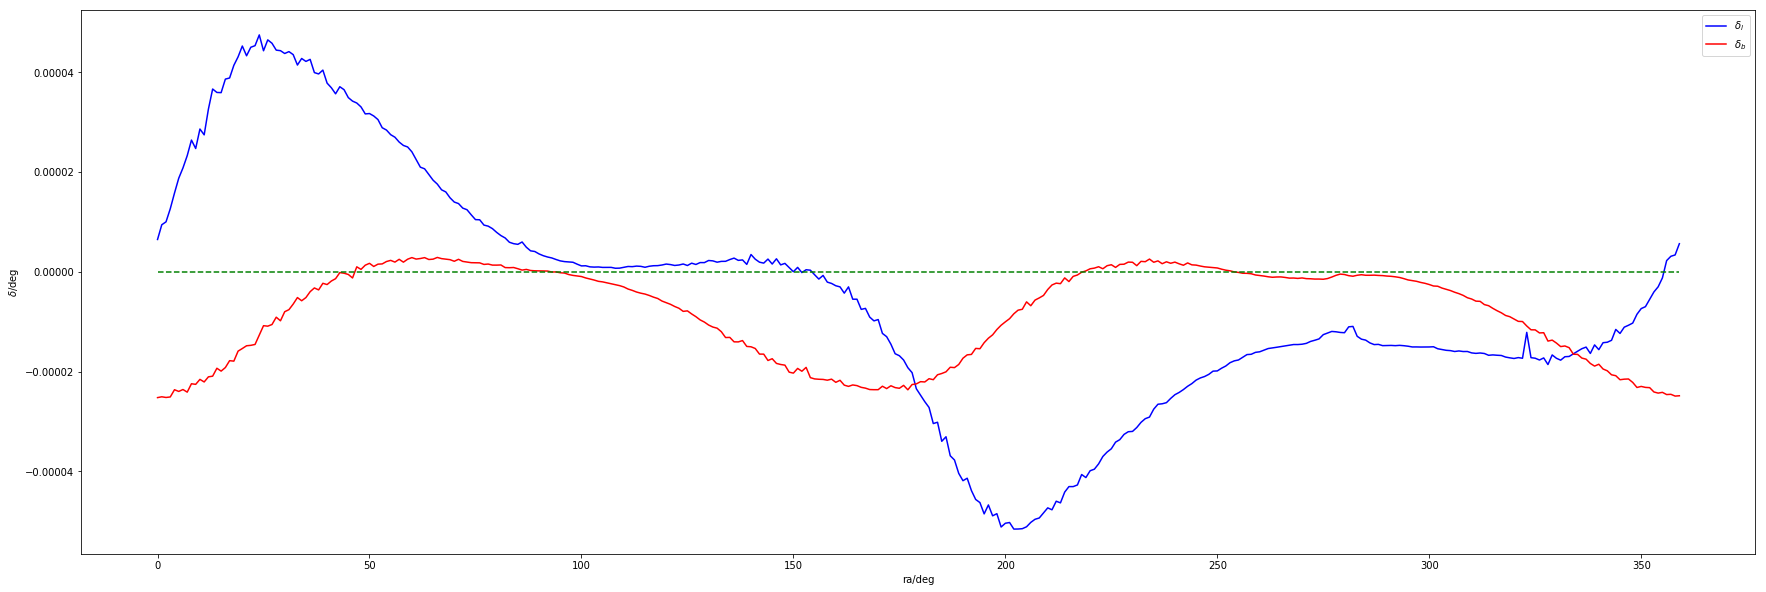

In [136]:
plt.figure(figsize=(30,10))
plt.plot(range(0,360),dl,'blue',label=r'$\delta_{l}$')
plt.plot(range(0,360),db,'red',label=r'$\delta_{b}$')
plt.plot(range(360),[0 for i in range(360)],'g--')
plt.xlabel('ra/deg')
plt.ylabel(r'$\delta$/deg')
#plt.title(r'$\delta_{dec}$ and $\delta_{ra}$ as the galactic coordinate l increasing by 0.05 degree and b decreasing by 0.02 degree')
plt.legend()

In [117]:
ram2=[]
decm2=[]
for i in range(1800):
    t=g[(g.ra>i/5)&(g.ra<=(i+1)/5)]
    if t.empty:
        continue
    ram2.append(np.mean(t.pmra)/100)
    decm2.append(np.mean(t.pmdec)/100)

In [121]:
len(ram2)

1800

In [130]:
dl=[[] for i in range(360)]
db=[[] for i in range(360)]
for i in range(0,1800):
    c1 = SkyCoord(ra=i/5*u.degree, dec=0*u.degree, frame='icrs')
    l=c1.galactic.l.deg
    dra=ram2[i]/3600
    ddec=decm2[i]/3600
    c2 = SkyCoord(ra=(i/5+dra)*u.degree, dec=ddec*u.degree, frame='icrs')
    dl[int(l)].append((c2.galactic.l.deg-c1.galactic.l.deg))
    db[int(l)].append((c2.galactic.b.deg-c1.galactic.b.deg))

In [131]:
dlm=[]
dbm=[]
for i in range(360):
    dlm.append(np.mean(dl[i]))
    dbm.append(np.mean(db[i]))

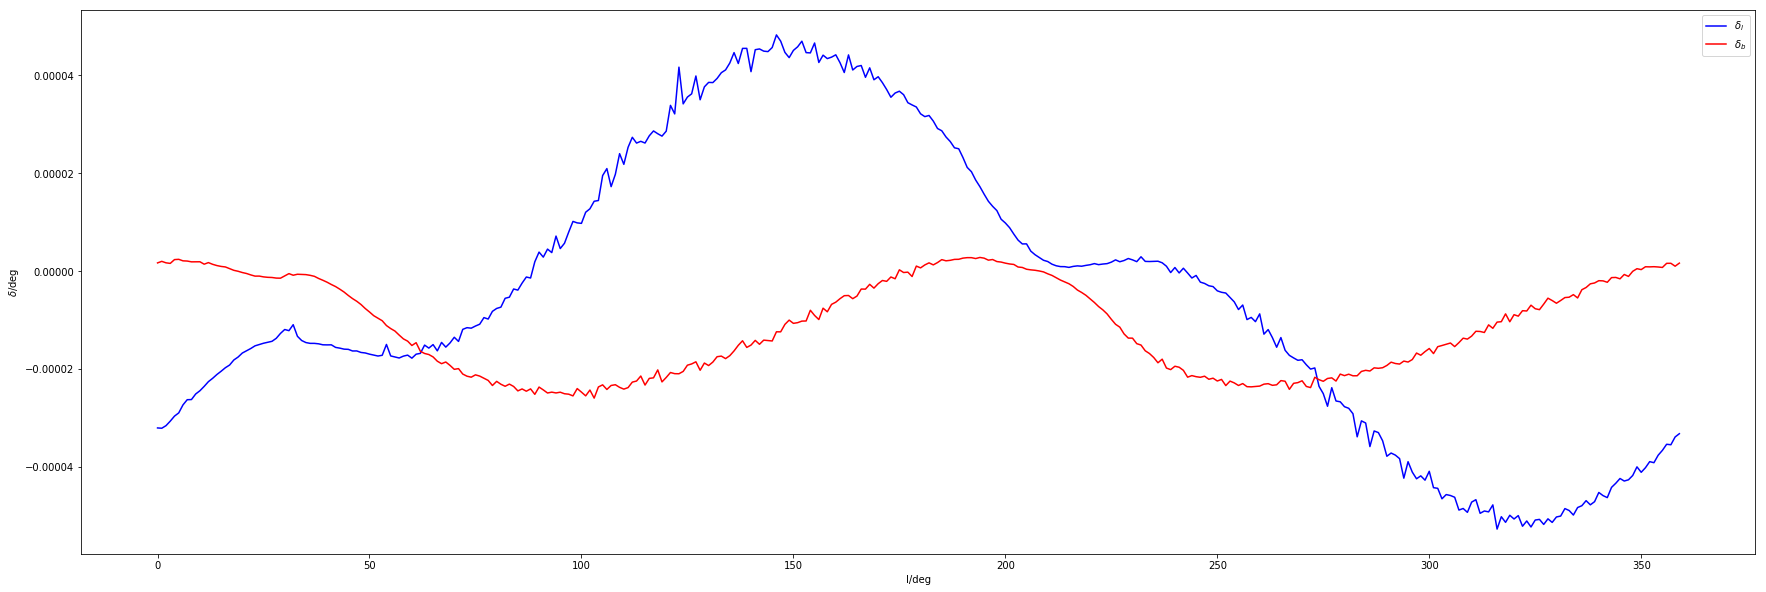

In [132]:
plt.figure(figsize=(30,10))
plt.plot(range(0,360),dlm,'blue',label=r'$\delta_{l}$')
plt.plot(range(0,360),dbm,'red',label=r'$\delta_{b}$')
plt.xlabel('l/deg')
plt.ylabel(r'$\delta$/deg')
#plt.title(r'$\delta_{dec}$ and $\delta_{ra}$ as the galactic coordinate l increasing by 0.05 degree and b decreasing by 0.02 degree')
plt.legend()

In [163]:
m=pd.read_csv('matchlist.csv')

In [172]:
m=m[m.matchednum!=0]

In [173]:
xm2=[]
ram2=[]
decm2=[]
rae2=[]
dece2=[]
for i in range(360):
    t2=m[(m.gra>i)&(m.gra<=(i+1))]
    if t2.empty:
        continue
    xm2.append(i)
    #mdelta_ra=(t.HSCra.values-t.S82ra1.values)*3600
    #mdelta_dec=(t.HSCdec.values-t.S82dec1.values)*3600
    #ram.append(np.mean(mdelta_ra))
    #decm.append(np.mean(mdelta_dec))
    ram2.append(np.mean(t2.pmra)/100)
    decm2.append(np.mean(t2.pmdec)/100)
    rae2.append(stats.sem(t2.pmra)/100)
    dece2.append(stats.sem(t2.pmdec)/100)

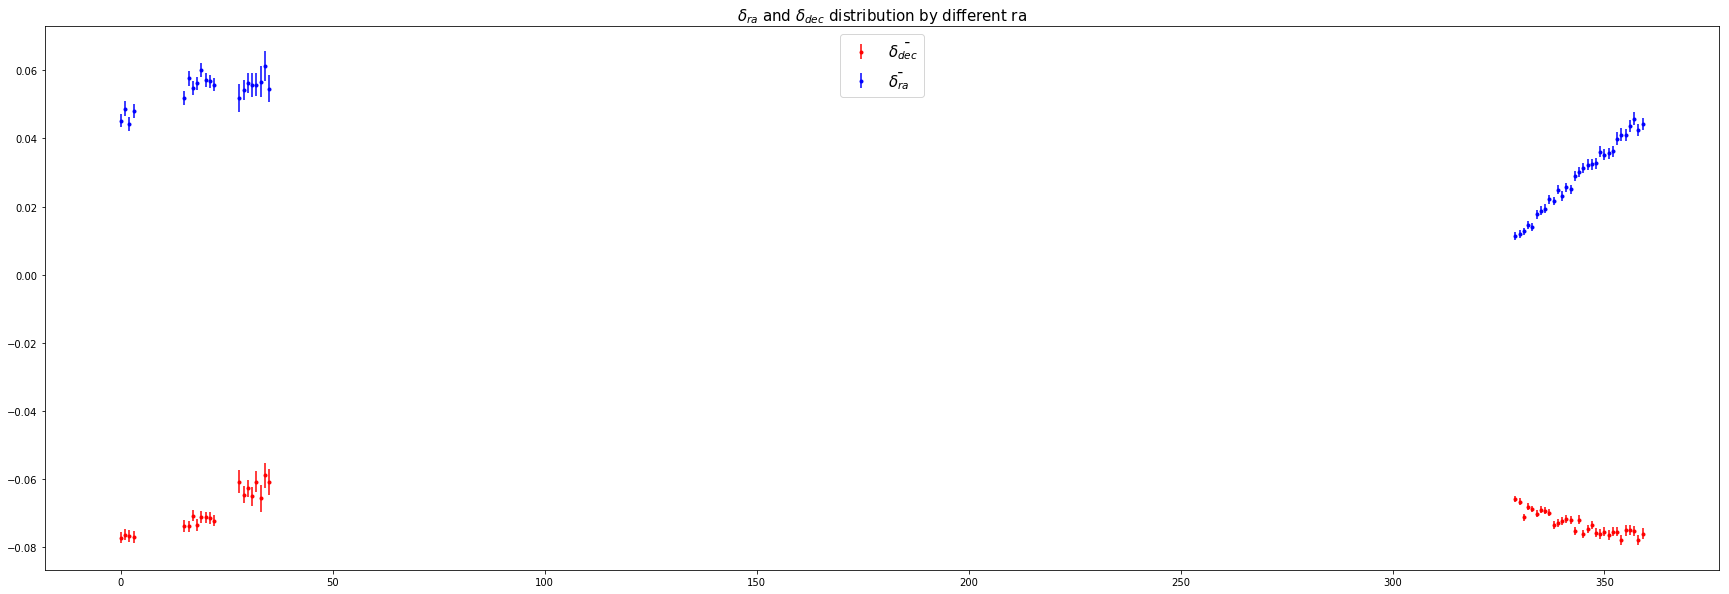

In [174]:
plt.figure(figsize=(30,10))
plt.errorbar(xm2,decm2,dece2,color='red', fmt='.', label=r'$\bar{\delta_{dec}}$')
plt.errorbar(xm2,ram2,rae2,color='blue', fmt='.', label=r'$\bar{\delta_{ra}}$')
plt.legend(loc=9,fontsize=15)
plt.title(r'$\delta_{ra}$ and $\delta_{dec}$ distribution by different ra',fontsize=15)
plt.savefig('gaia_pm_matched_gaia_errorbar.png')

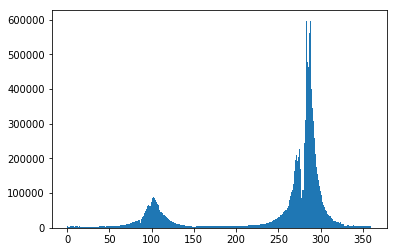

In [36]:
plt.hist(g.ra,bins=360)
plt.savefig('ra_hist.png')

In [28]:
gm=g[(g.ra<4)|((g.ra>15)&(g.ra<23))|((g.ra>28)&(g.ra<36))|(g.ra>329)]

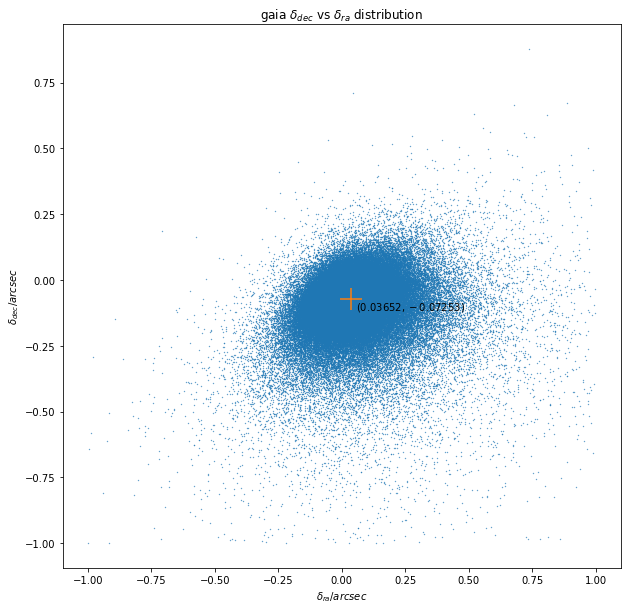

In [39]:
plt.figure(figsize=(10,10))
plt.title(r'gaia $\delta_{dec}$ vs $\delta_{ra}$ distribution')
plt.scatter(gm.pmra/100,gm.pmdec/100,alpha=1,s=0.1)
plt.scatter(np.mean(gm.pmra)/100,np.mean(gm.pmdec)/100,s=500,marker='+')
plt.text(np.mean(gm.pmra)/100+0.02,np.mean(gm.pmdec)/100-0.04,'$(%0.5f,%0.5f)$'%(np.mean(gm.pmra)/100,np.mean(gm.pmdec)/100))
plt.xlabel(r'$\delta_{ra}/arcsec$')
plt.ylabel(r'$\delta_{dec}/arcsec$')
plt.savefig('delta_dist.png')

In [45]:
mm=[[]*i for i in range(3)]
for i in range(3):
    mm[i]=gm[(gm.phot_g_mean_mag>=18+i)&(gm.phot_g_mean_mag<19+i)]

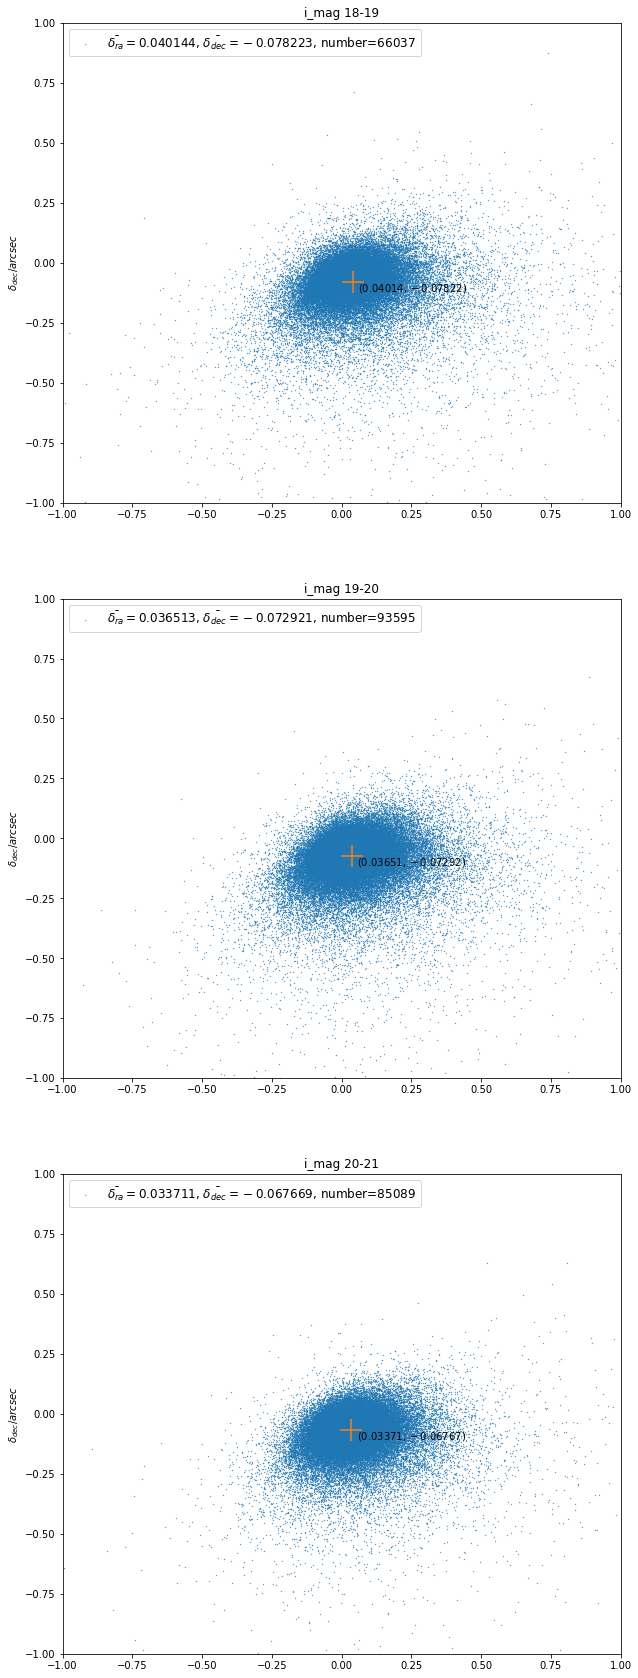

In [47]:
plt.figure(figsize=(10,30))
for i in range(3):
    mram=np.mean(mm[i].pmra)/100
    mdecm=np.mean(mm[i].pmdec)/100
    plt.subplot(311+i)
    plt.title(r'i_mag '+str(18+i)+'-'+str(19+i))
    plt.scatter(mm[i].pmra/100,mm[i].pmdec/100,alpha=1,s=0.1,label=r'$\bar{\delta_{ra}}=%f$, $\bar{\delta_{dec}}=%f$, number=%.0f'%(mram,mdecm,len(mm[i])))
    plt.scatter(mram,mdecm,s=500,marker='+')
    plt.text(mram+0.02,mdecm-0.04,'$(%0.5f,%0.5f)$'%(mram,mdecm))
    plt.ylabel(r'$\delta_{dec}/arcsec$')
    plt.legend(loc=2,fontsize=12)
    plt.axis([-1,1,-1,1])
plt.savefig('delta_dist_mag.png')

In [48]:
#after ovelap with HSCol

In [49]:
go=pd.read_csv('gaiaol.csv')

In [53]:
mm=[[]*i for i in range(3)]
for i in range(3):
    mm[i]=go[(go.phot_g_mean_mag>=18+i)&(go.phot_g_mean_mag<19+i)]

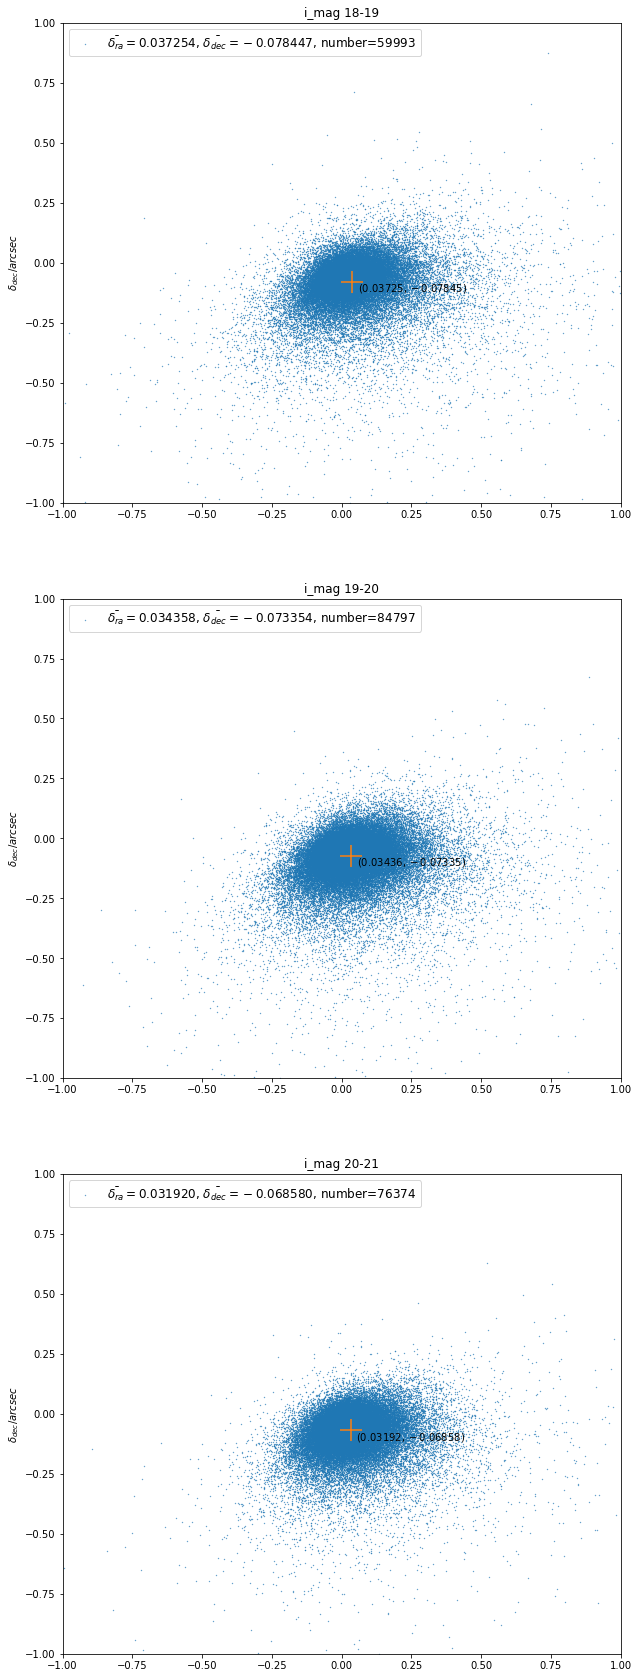

In [112]:
plt.figure(figsize=(10,30))
for i in range(3):
    mram=np.mean(mm[i].pmra)/100
    mdecm=np.mean(mm[i].pmdec)/100
    plt.subplot(311+i)
    plt.title(r'i_mag '+str(18+i)+'-'+str(19+i))
    plt.scatter(mm[i].pmra/100,mm[i].pmdec/100,alpha=1,s=0.1,label=r'$\bar{\delta_{ra}}=%f$, $\bar{\delta_{dec}}=%f$, number=%.0f'%(mram,mdecm,len(mm[i])))
    plt.scatter(mram,mdecm,s=500,marker='+')
    plt.text(mram+0.02,mdecm-0.04,'$(%0.5f,%0.5f)$'%(mram,mdecm))
    plt.ylabel(r'$\delta_{dec}/arcsec$')
    plt.legend(loc=2,fontsize=12)
    plt.axis([-1,1,-1,1])
plt.savefig('delta_dist_mag_matched_star.png')


In [143]:
xm3=[]
ram3=[]
decm3=[]
rae3=[]
dece3=[]
for i in range(360):
    t3=go[(go.ra>i)&(go.ra<=(i+1))]
    if t3.empty:
        continue
    xm3.append(i)
    #mdelta_ra=(t.HSCra.values-t.S82ra1.values)*3600
    #mdelta_dec=(t.HSCdec.values-t.S82dec1.values)*3600
    #ram.append(np.mean(mdelta_ra))
    #decm.append(np.mean(mdelta_dec))
    ram3.append(np.mean(t3.pmra)/100)
    decm3.append(np.mean(t3.pmdec)/100)
    rae3.append(stats.sem(t3.pmra)/100)
    dece3.append(stats.sem(t3.pmdec)/100)

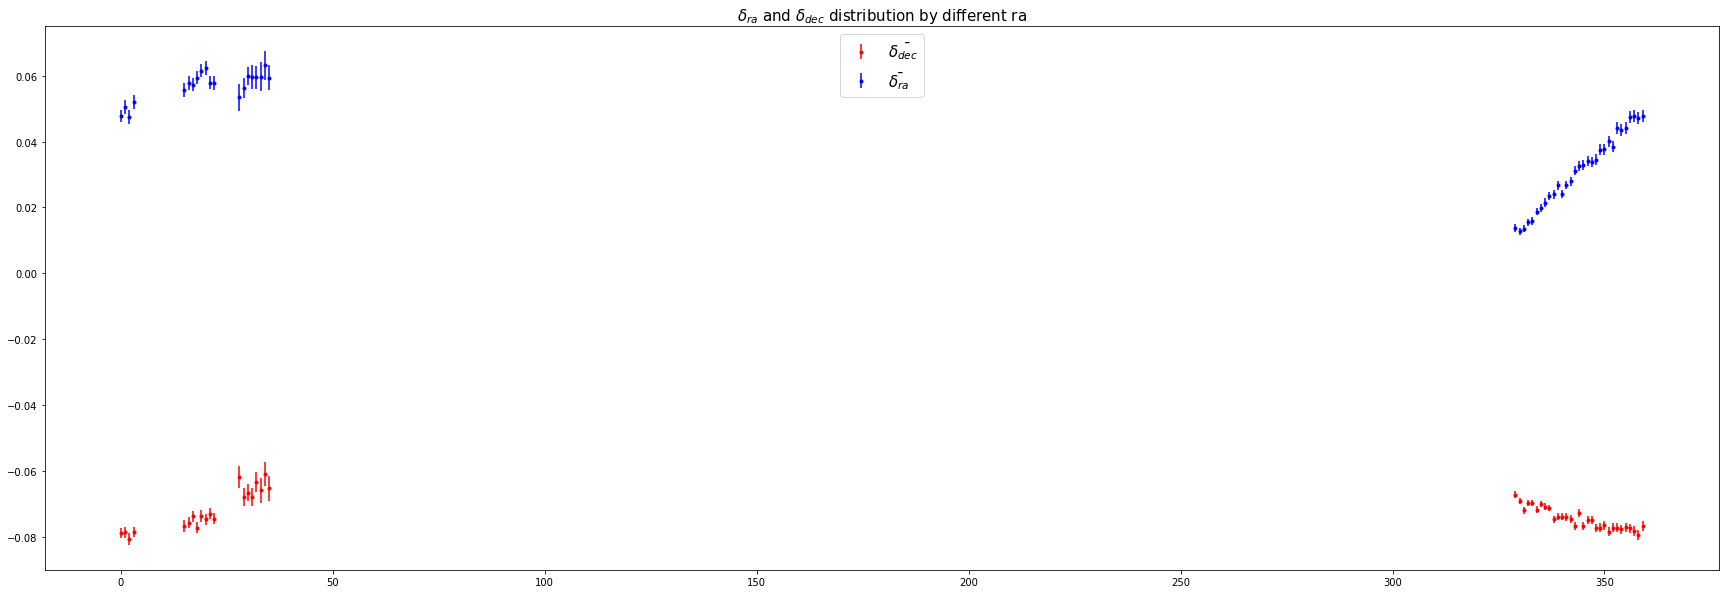

In [182]:
plt.figure(figsize=(30,10))
plt.errorbar(xm3,decm3,dece3,color='red', fmt='.', label=r'$\bar{\delta_{dec}}$')
plt.errorbar(xm3,ram3,rae3,color='blue', fmt='.', label=r'$\bar{\delta_{ra}}$')
plt.legend(loc=9,fontsize=15)
plt.title(r'$\delta_{ra}$ and $\delta_{dec}$ distribution by different ra',fontsize=15)
plt.savefig('gaia_pm_overlapped_gaia_errorbar.png')

In [179]:
np.mean(go[(go.ra>10)&(go.ra<=(20))].pmra)

5.831150539676253

In [180]:
np.mean(m[(m.gra>10)&(m.gra<=(20))].pmra)

5.617881433962961